<h1>
    <p style="text-align: center;"> STATS 131 - State-space Models of Spiking Neurons </p>
    <p style="text-align: center;"> Demba Ba</p>
    <p style="text-align: center;"> Tuesday, November 2 2017</p>
</h1>

In [6]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [7]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%matplotlib inline
import os
import glob
import csv
import time
import pandas as pd
from   pylab import *
from   urllib import urlopen
from   datetime import datetime
import numpy as np
import sys
import math
from   operator import truediv
from   pandas.io.json import json_normalize
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from wand.image import Image as WImage

#sys.path.insert(1,'/Users/zyzdiana/Github/AC299r/code')
#from visualize import plot_raw_data, get_population_data

In [9]:
%qtconsole

# Data from neuroscience experiments

One of the main goals of neuroscience research is to characterize how neural/brain activity translates to behavior. This requires an understanding of how neurons operate at various temporal and spatial scales. The importance of understanding how single neurons work must be coupled with an understanding of the brain at larger scales.

There exists a vast array of data that can be acquired from the brain. Inherent in our quest to understand the brain is a trade off between the temporal and the spatial scales at which we can probe the brain. The wholy grail of neuroscience research is to be able to record simultaneously from every neuron in the brain. 

## Trade off between temporal and spatial resolution in recordings from the brain

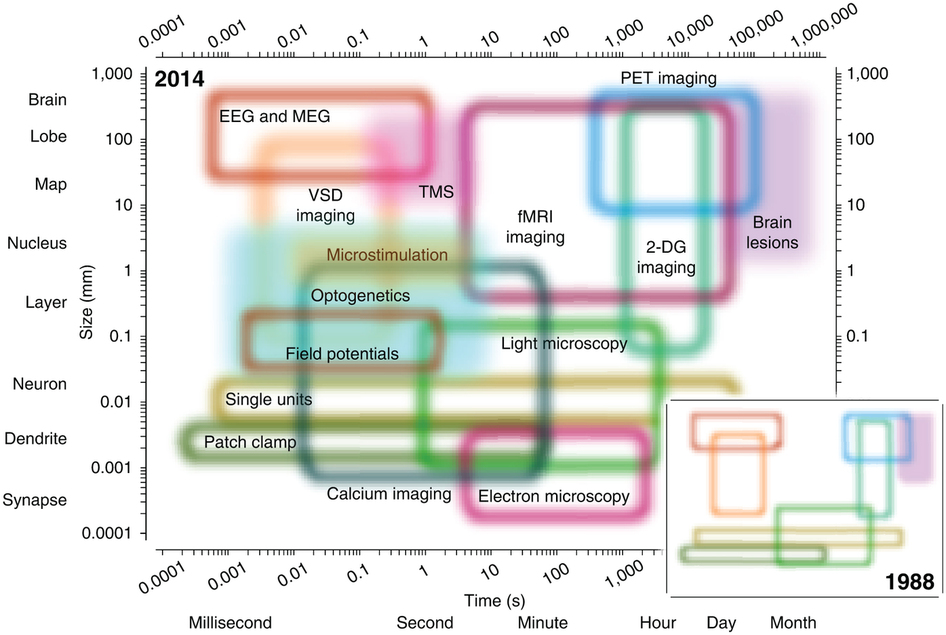

In [61]:
img0 = WImage(filename='neuro_res.jpg')#,resolution=600)
#img1.resize(700,500)
img0

## Neural spiking activity from single neurons

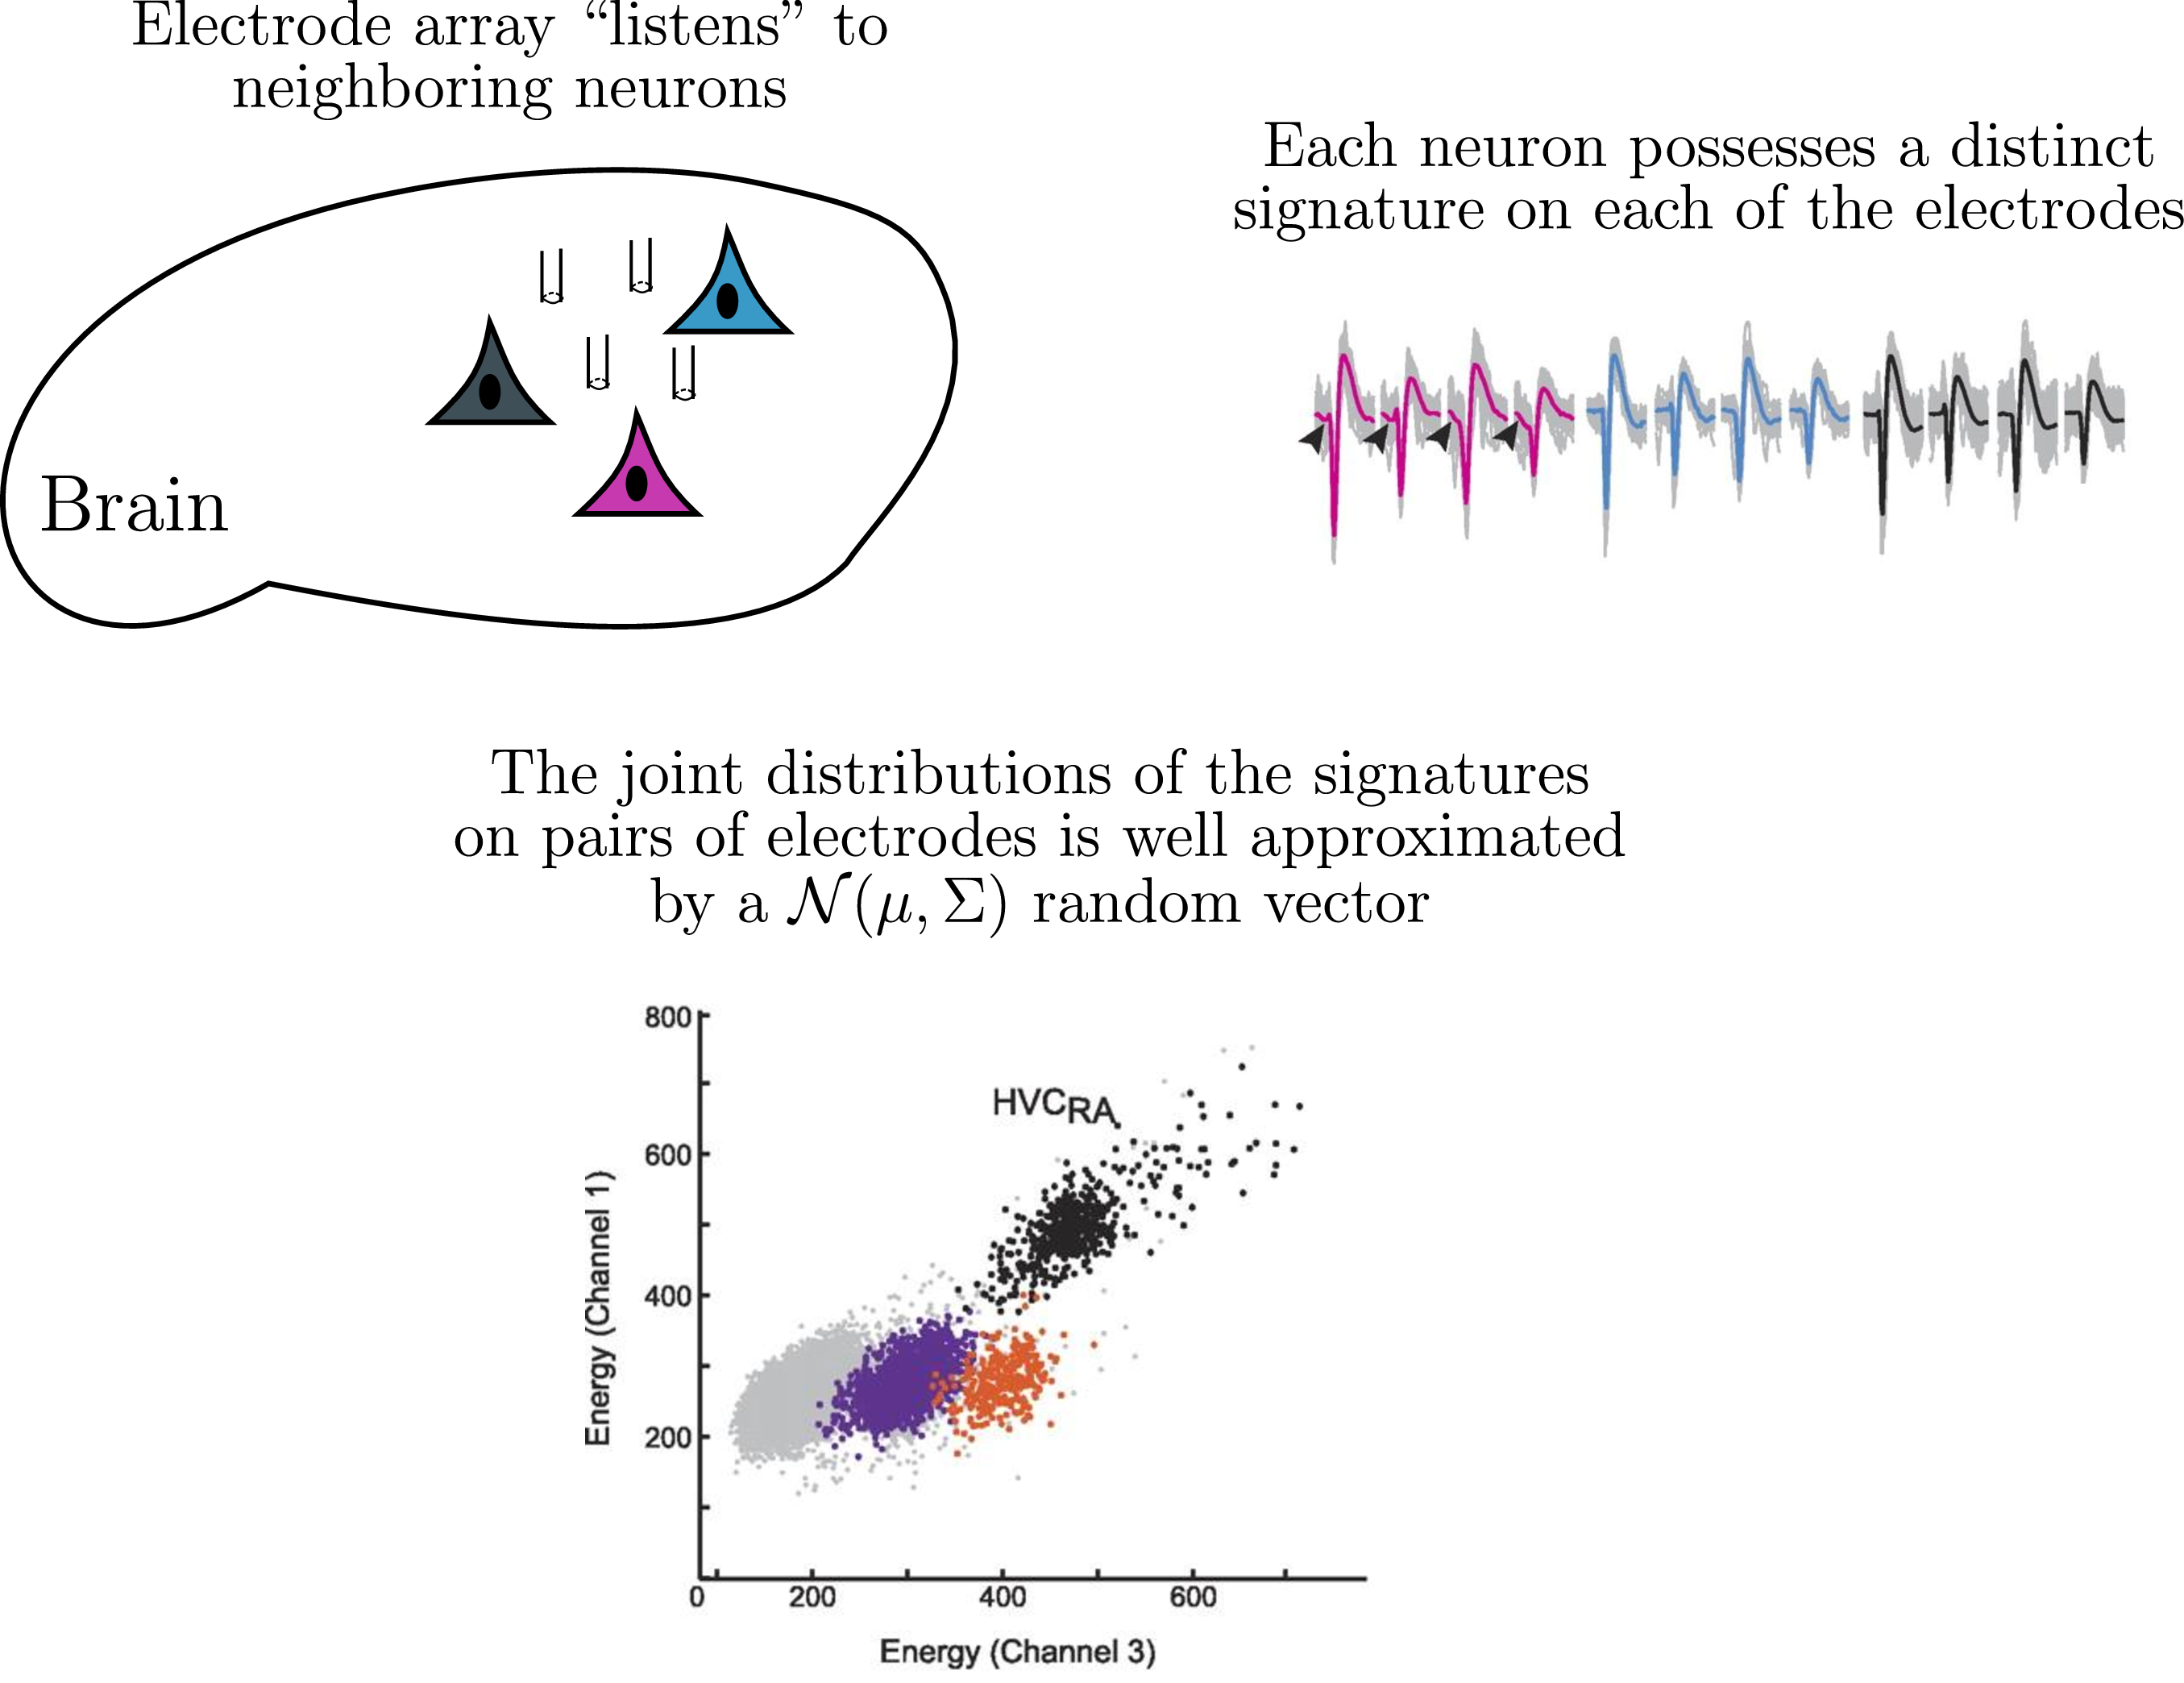

In [66]:
img0b = WImage(filename='spike_sorting.pdf',resolution=600)
#img1.resize(700,500)
img0b

In [64]:
from IPython.display import YouTubeVideo
# a talk about IPython at Sage Days at U. Washington, Seattle.
# Video credit: William Stein.

### Hubel and Wiesel (vision work)

In [65]:
YouTubeVideo('IOHayh06LJ4')

### Hippocampal place cells: a neural code of position

In [63]:
YouTubeVideo('bL0WLyMLwqw')

$(0,T]$: Observation interval

$C$: Total number of neurons

$dN_{0,t}^{c}$: sample path of spike times from neuron $c$ in $(0,t]$, for $t \in (0,T]$, and $c = 1,...,C$

$x(t)$: position of animal at time $t$.

$K$: divide $(0,T]$ into $K$ intervals with width $\Delta = \frac{T}{K}$ such that there is at most one spike per interval

$k\Delta$: The point at which the latent process model is evaluated, for $k = 1,...,K$

$\Delta N_k^c$: The number of spikes at time k from neuron c.

$x_k$ position of animal at time k.

### Model of a hipppocampal neuron (encoding)

The rate function of neuron $c$ is modeled as a Gaussian with a mean and variance that can be estimated from data

\begin{equation}
    \lambda_c(k\Delta) = \frac{1}{(2\pi \sigma^2_c)^{1/2}} exp\left\{-\frac{(x_k - \mu_c)^2}{2\sigma^2_c}\right\} 
\end{equation}

### Decoding animal position from neural data

We can use a state space model to ``read'' or decode the animal's position from the neural data from $C$ neurons

$$\left\{
\begin{array}{ll}
      x_k = x_{k-1} + \epsilon_k, \epsilon_k \sim N(0,\sigma^2_{\epsilon}) & (1) \\
      \text{log } \lambda_c(k\Delta)\Delta \propto -\frac{(x_k - \hat{\mu}_c)^2}{2\hat{\sigma}^2_c} & (2)\\
      \Delta N_{k}^{c} | x_k \sim Bernoulli(\lambda_c(k\Delta)\Delta) & (3)\\
\end{array} 
\right. $$

# Linear Gaussian state-space model and the Kalman filter

Consider the following state-space model for $k=1,\cdots,K$

$$\left\{
\begin{array}{ll}
      x_k = x_{k-1} + \epsilon_k, \epsilon_k \sim N(0,\sigma^2_{\epsilon}) & (1) \\
      y_k = x_k + \delta_k  \sim N(0,\sigma^2_{\delta}) & (2)\\
\end{array} 
\right. $$

## Kalman fiter

Given initation conditons $x_{0|0} = 0$ and $\sigma^2_{0|0} = 0$, for $k=1,\cdots,K$

$$x_{k|k-1} = x_{k-1|k-1}$$

$$\sigma^2_{k|k-1} = \sigma^2_{k-1|k-1}+\sigma^2_{\epsilon}$$

$$x_{k|k} = x_{k|k-1} + \frac{\sigma^2_{k|k-1}}{\sigma^2_\delta + \sigma^2_{k|k-1}}\left( y_k - x_{k|k-1}\right)$$

$$
\sigma^2_{k|k} = \left[\frac{1}{\sigma^2_{k|k-1}} + \frac{1}{\sigma^2_\delta}\right]^{-1}
$$


## Kalman smoother

Starting with $x_{K|K}$ and $\sigma^2_{K|K}$ from the last step of the filter, for $k=K-1,\cdots,1$

\begin{eqnarray}
	x_{k|K} & = & x_{k|k} + \frac{\sigma^2_{k|k}}{\sigma^2_{k+1|k}}(x_{k+1|K}-x_{k+1|k})\\
	\sigma^2_{k|K} & = & \sigma^2_{k|k} + \left(\frac{\sigma^2_{k|k}}{\sigma^2_{k+1|k}}\right)^2 (\sigma^2_{k+1|K} - \sigma^2_{k|k}).
\end{eqnarray}

## Toy example

### Generate clean signal

We will assume that the observed data is the sum of a **deterministic** signal $s$ and additive Gaussian noise with variance that is a function of a given $SNR$ and the energy of the signal $s$.

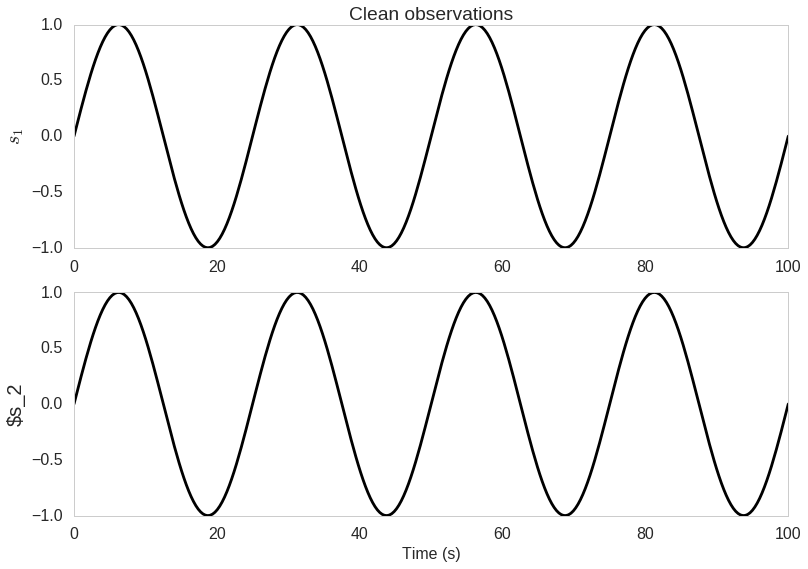

In [85]:
# Generate complex-valued Gaussian random vector
t = linspace(0,100,300)
K = t.shape[0]

# Real part is an oscillation with period T0
T0 = 25.0
s1 = cos(2*pi*(t-(T0/4))/T0)

# Imaginary part is linear
s2 = t/100

# normalize real and imaginary parts so that they have the same energy
s2 = sqrt(var(s1)/var(s1))*s1

figure(1)
subplot(2,1,1)
plot(t,s1,'k')
plt.grid('off')
title('Clean observations')
ylabel('$s_1$',fontsize=20)
subplot(2,1,2)
plot(t,s2,'k')
plt.grid('off')
ylabel('$s_2',fontsize=20)
xlabel('Time (s)',fontsize=16);

### Add Gaussian noise with a given SNR

$$ SNR = 10 \cdot \text{log}_{10} \frac{\sigma^2_{s}}{\sigma^2_v}$$

$$ \sigma^2_v = \sigma^2_{s} 10^{-SNR/10}$$

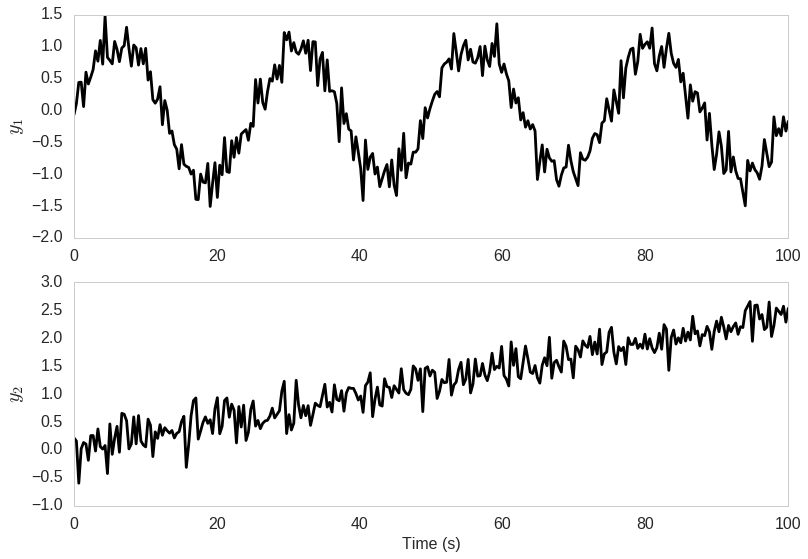

In [86]:
# Add Gaussian noise (based on real part, which is 0 mean)
snr = 10 # in dB

sigma2e = var(s1) + var(s2)

sigma2v = sigma2e*10**(-snr/10)

y1 = (sRe + sqrt(sigma2v/2)*randn(K))
y2 = (sIm + sqrt(sigma2v/2)*randn(K))

figure(2)
subplot(2,1,1)
plot(t,y1,'k')
plt.grid('off')
ylabel('$y_1$',fontsize=20)
subplot(2,1,2)
plot(t,y2,'k')
plt.grid('off')
ylabel('$y_2$',fontsize=20)
xlabel('Time (s)',fontsize=16);

### Kalman filter

In [87]:
def KalFilt(y,sigma2v,sigma2e,xbar0,sigma20):
    
    # signal length
    K = y.shape[0]
    
    #filter data structures
    xprior = zeros(K,dtype=float) # one-step prediction: xprior[k] = x_{k|k-1}
    s2prior = zeros(K,dtype=float) # \sigma^2_{k|k-1}
    
    xpost = zeros(K,dtype=float) # posterior at time k: xpost[k] = x_{k|k}
    s2post = zeros(K,dtype=float) # \sigma^2_{k|k}

    for k in range(K):
        
        if k == 1:
            xprior[k] = xbar0
            s2prior[k] = sigma20 + sigma2e
        else:
            xprior[k] = xpost[k-1]
            s2prior[k] = s2post[k-1] + sigma2e
        
        ck = sigma2v/(sigma2v + s2prior[k])
        
        xpost[k] = xprior[k] + ck*(y[k]-xprior[k])
        
        s2post[k] = 1.0/(1.0/sigma2v + 1.0/s2prior[k])
        
    return (xpost,s2post)

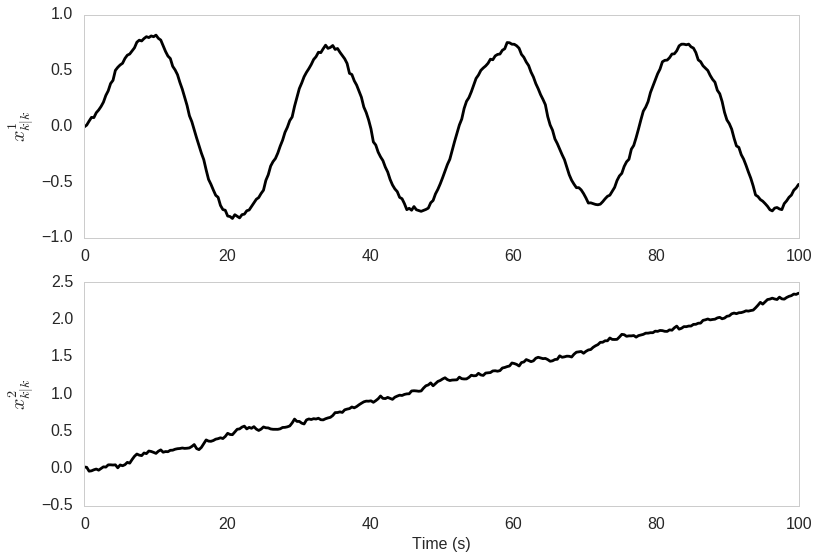

In [89]:
xbar0 = 0
sigma20 = 0
(x1post,s2post1) = KalFilt(y1,sigma2v,sigma2e,xbar0,sigma20)
(x2post,s2post2) = KalFilt(y2,sigma2v,sigma2e,xbar0,sigma20)


figure(3)
subplot(2,1,1)
plot(t,x1post,'k')
plt.grid('off')
ylabel('$x_{k|k}^1$',fontsize=20)
subplot(2,1,2)
plot(t,x2post,'k')
plt.grid('off')
ylabel('$x_{k|k}^2$',fontsize=20)
xlabel('Time (s)',fontsize=16);

# Neural spiking rates

In [14]:
from visualize import plot_raw_data,bokeh_plot_raster,get_population_data

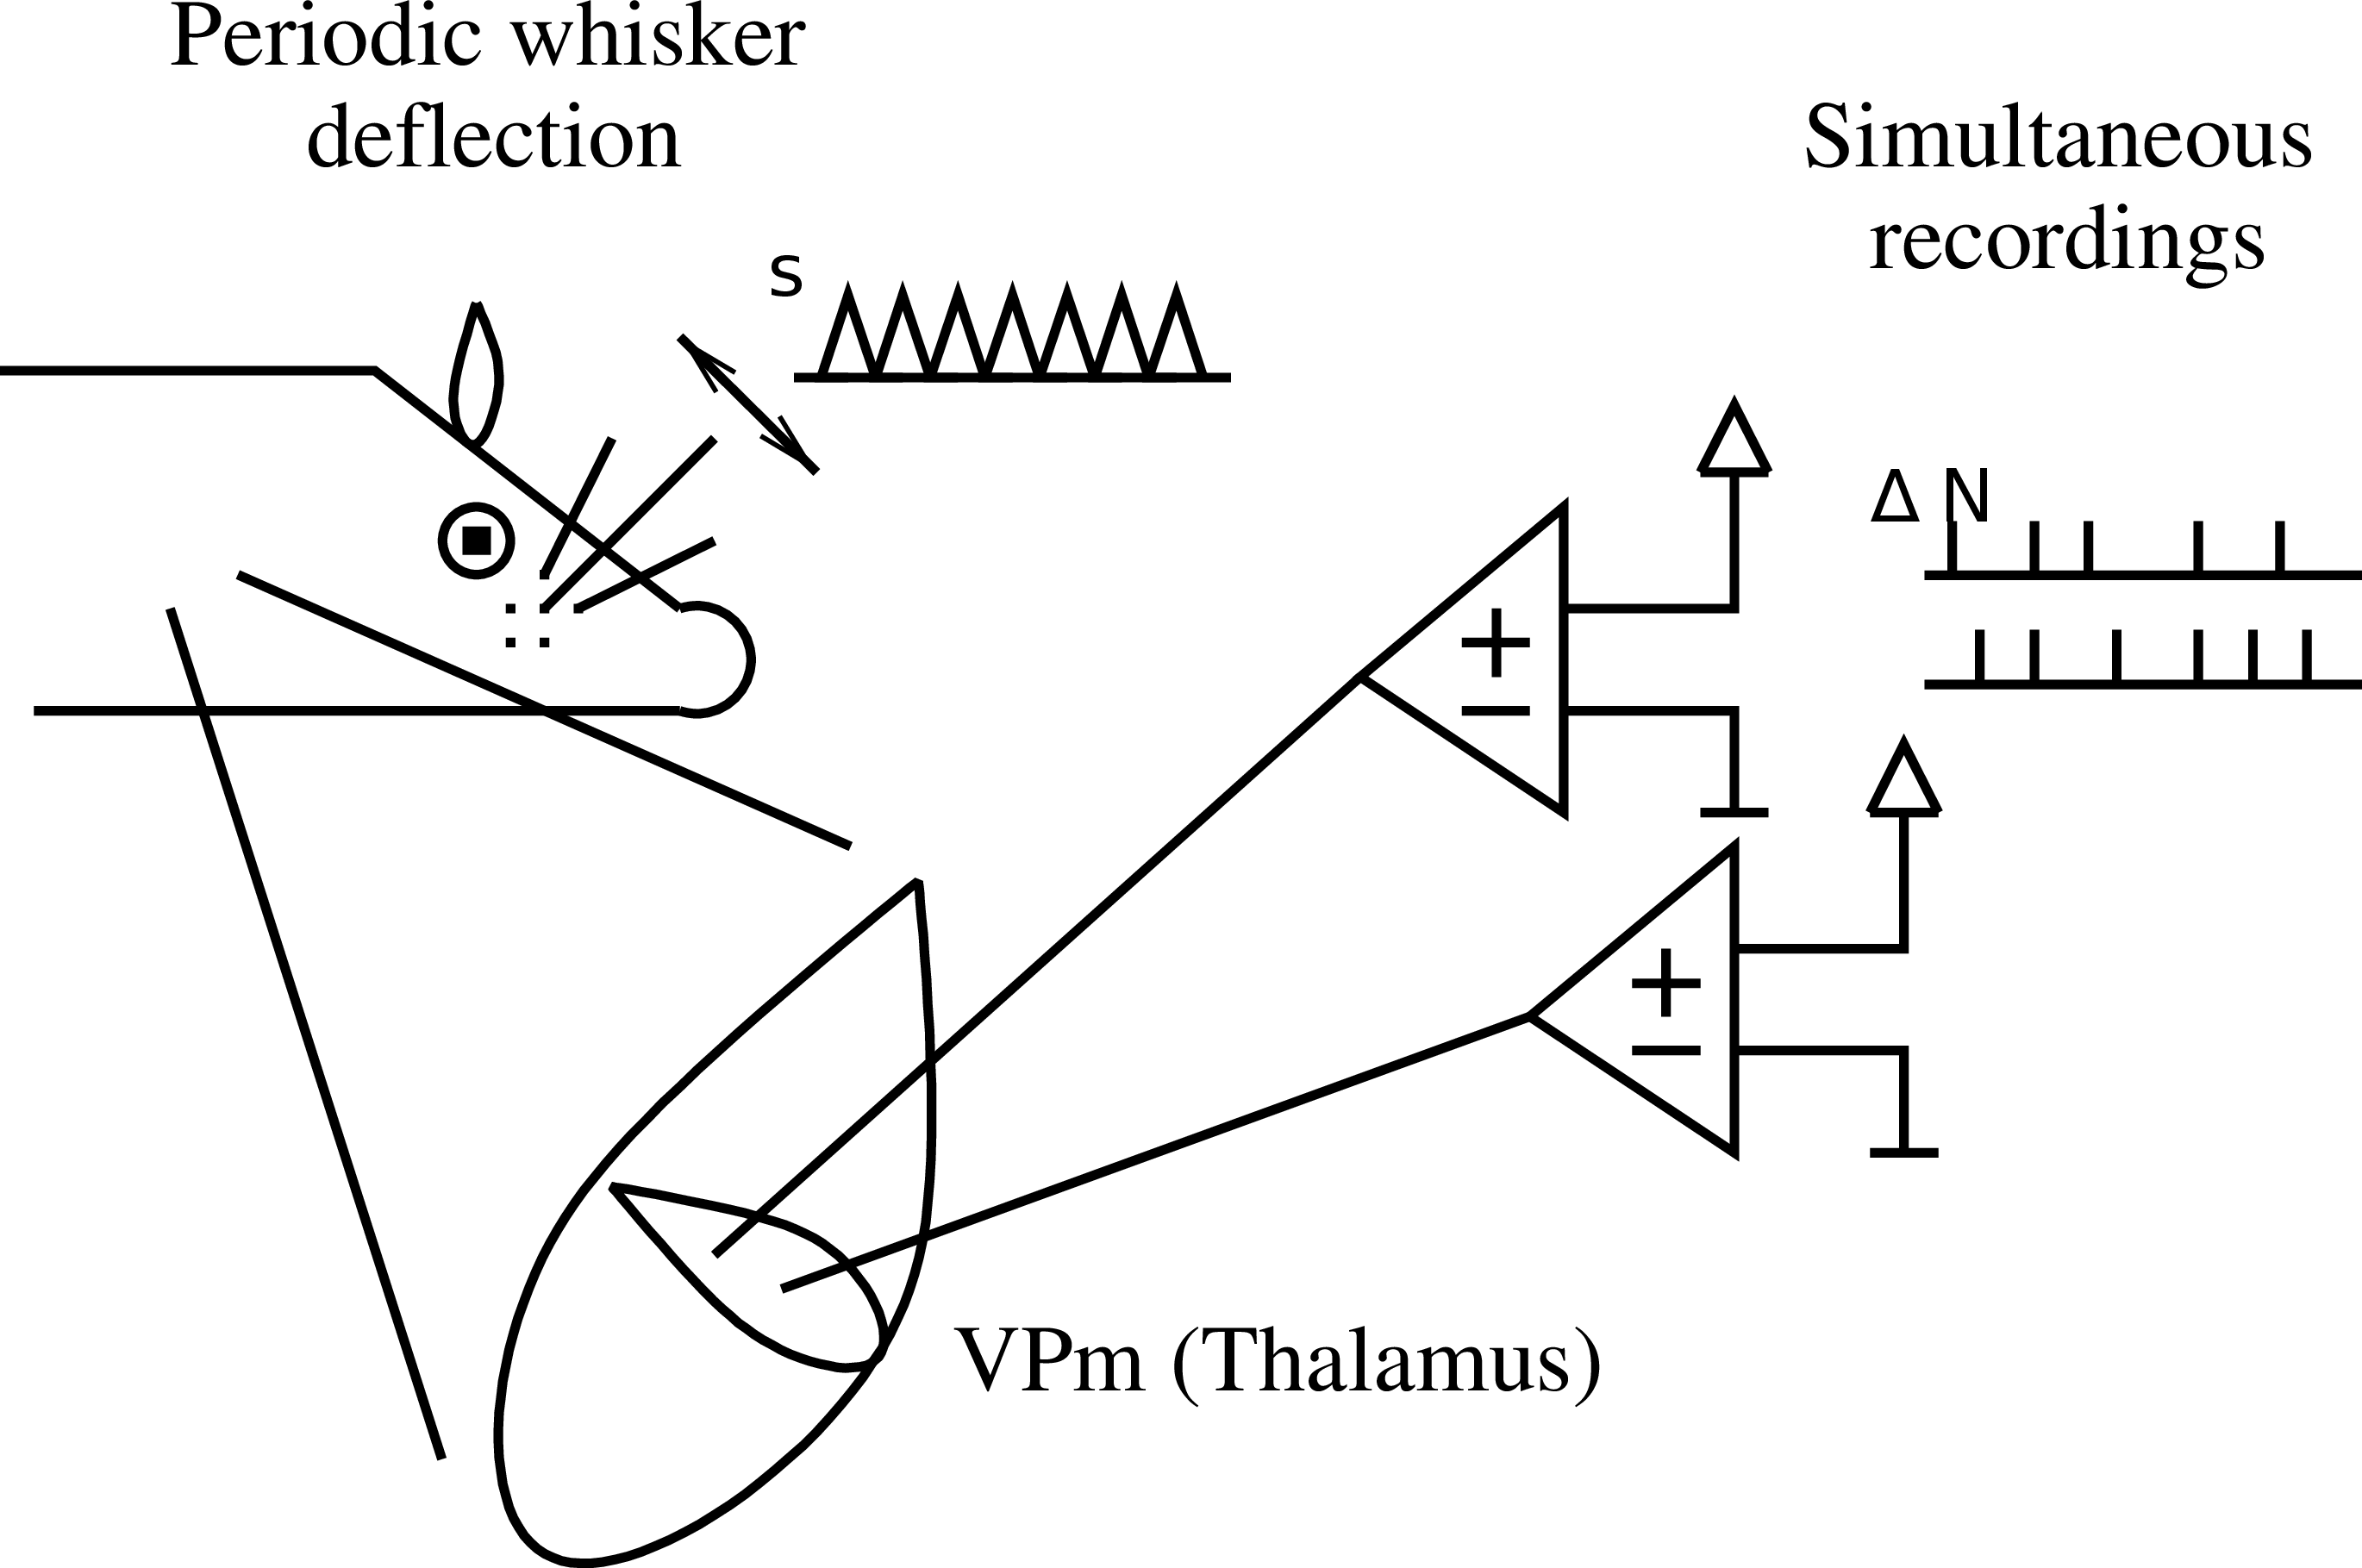

In [53]:
img1 = WImage(filename='whisking_xprmnt.pdf',resolution=600)
#img1.resize(700,500)
img1

In [17]:
# Get a set of whisker data and plot the raster plot
cellnum = 17
neuron = 1
stim = 3
resp_values_whisker,t = get_population_data(cellnum,neuron,stim)

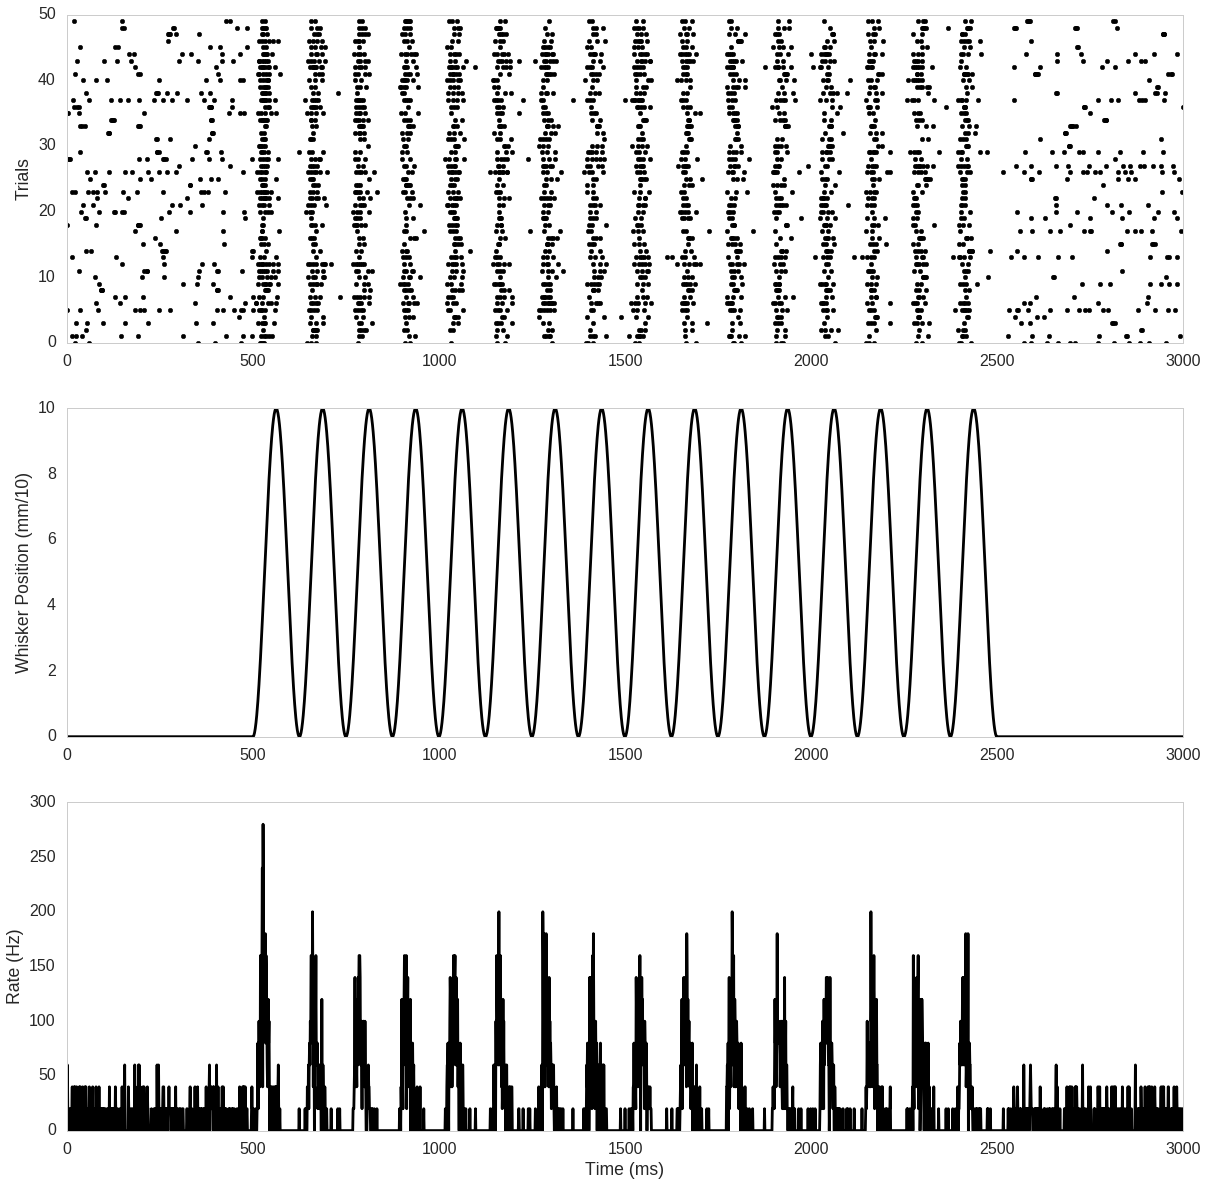

In [18]:
Rwhisker, Kwhisker = resp_values_whisker.shape
Iwhisker, Jwhisker = np.where(resp_values_whisker != 0)

# change the size of the figure [width, height]
fig1 = plt.figure(figsize=(20, 20)) 
subplot(3,1,1)

# turn on/off grid
plt.grid('off')

# Plot Raster
# change the size of the figure [width, height]
plt.scatter(Jwhisker, Iwhisker, c='black');
#plt.yticks(np.arange(0,50,5), ytick_labels, rotation='horizontal')

# axis dimensions
plt.xlim([0, 3000])
plt.ylim([0, 50])

# turn on/off grid
plt.grid('off')

# axis labels
plt.ylabel('Trials');#, fontsize = global_fontsize)

subplot(3,1,2)

# Plot Raster
# change the size of the figure [width, height]
#ax2 = plt.subplot(gs[:4,1:])
plt.plot(t[0][:3000],'k');
#plt.yticks(np.arange(0,50,5), ytick_labels, rotation='horizontal')

# axis dimensions
plt.xlim([0, 3000])
plt.ylim([0, 10])

# turn on/off grid
plt.grid('off');

plt.ylabel('Whisker Position (mm/10)');#, fontsize = global_fontsize)

subplot(3,1,3)
plt.grid('off');


plt.plot(mean(resp_values_whisker,axis=0)*1000,'k');

# axis labels
plt.ylabel('Rate (Hz)');
plt.xlabel('Time (ms)');#, fontsize = global_fontsize)

plt.show();

# State-space models of neural data

$(0,T]$: Observation interval

$R$: Total number of trials

$dN_{0,t}^{r}$: sample path of spike times for trial $r$ in $(0,t]$, for $t \in (0,T]$, and $c = 1,...,C$

$dN_{0,t} = \{dN_{0,t}^{1},...,dN_{0,t}^{C}\}$: ensemble spiking activity in $(0,t]$

$S_{0,t} = \{0 < s_1 < ,..., < s_{\ell}\leq t\}$: set of stimuli applied in $(0,t]$

$H_t = \{N_{0,t},S_{0,t}\}$: history of all C neurons in $(0,t]$

$K$: divide $(0,T]$ into $K$ intervals with width $\Delta = \frac{T}{K}$ such that there is at most one spike per interval

$k\Delta$: The point at which the latent process model is evaluated, for $k = 1,...,K$

$\Delta N_k^r$: The number of spikes at time k and trial r.

# Whisker Experiment Data

Let $R$ denote the total number of trials, a state space model for the rate function of a single neuron neuron data can be defined as

$$\left\{
\begin{array}{ll}
      x_k = x_{k-1} + \epsilon_k, \epsilon_k \sim N(0,\sigma^2_{\epsilon}) & (1) \\
      \lambda_r(k\Delta)\Delta = \frac{e^{x_k}}{1+e^{x_k}} & (2)\\
      \Delta N_{k}^{r} | x_k \sim Bernoulli(\lambda_r(k\Delta)\Delta) & (3)\\
\end{array} 
\right. $$

From $(2)$ we have $$\log \left(\frac{\lambda_r(k\Delta)\Delta}{1-\lambda_r(k\Delta)\Delta}\right) = x_k$$

From $(3)$ we have 
$$\begin{align*}p(\Delta N_{k}^r|x_k) &= \lambda_r(k\Delta)\Delta^{\Delta N_{k}^r}(1-\lambda_r(k\Delta)\Delta)^{1-\Delta N_{k}^r}\\
&= \left(\frac{\lambda_r(k\Delta)\Delta}{1-\lambda_r(k\Delta)\Delta}\right)^{\Delta N_{k}^r}(1-\lambda_r(k\Delta)\Delta)\\
\\
\end{align*}$$

Let $\Delta N_k = (\Delta N_k^1,\Delta N_k^2,\cdots,\Delta N_k^R)'$.

## Derivation of Filter Equations


### 1. Bayes' rule
The posterior equation is computed from Baye's Rule:
$$\begin{align*}
p(x_k|H_{k}) &= \frac{p(x_k|H_{k-1})p(\Delta N_k|x_k,H_{k-1})}{p(\Delta N_k|H_{k-1})}\\
& \propto p(x_k|H_{k-1})p(\Delta N_k|x_k,H_{k-1})
\end{align*}$$

**Gaussian approximation for one-step prediction and filter densities**

We still need to assume that for all k 

$$x_k|H_{k} \sim N(x_{{k}|{k}}, \sigma^2_{k|k})$$

$$x_k|H_{k-1} \sim N(x_{{k}|{k-1}}, \sigma^2_{k|k-1})$$


### 2. Chapman-Kolmogorov recursion

The one-step Chapman-Kolomogorov recursion equations is:

$$p(x_k|H_{k-1}) = \int_{x_{k-1}}p(x_k|x_{k-1})p(x_{k-1}|H_{k-1}) dx_{k-1}$$.

Hence,

$$x_{k|k-1} = x_{k-1|k-1}$$

$$\sigma^2_{k|k-1} = \sigma^2_{k-1|k-1}+\sigma^2_{\epsilon}$$


**Appliocation of Bayes' rule yields,**
$$\begin{align*}
p(x_k|H_{k}) & \propto \left\{\frac{1}{\sqrt{2\pi\sigma^2_{k|k-1}}}\exp\left(-\frac{1}{2}\frac{(x_k- x_{{k}|{k-1}})^2}{\sigma^2_{k|k-1}}\right)\right\} \times \left\{\prod\limits_{r=1}^{R} \left(\frac{\lambda_r(k\Delta)\Delta}{1-\lambda_r(k\Delta)\Delta}\right)^{\Delta N_{k}^r}(1-\lambda_r(k\Delta)\Delta)\right\}
\end{align*}$$

$$\begin{align*}
\log p(x_k|H_{k}) &= -\frac{1}{2}\frac{(x_k-x_{{k}|{k-1}})^2}{\sigma^2_{k|k-1}} + \sum\limits_{r=1}^{R} \left\{\log\left[ \left(\frac{\lambda_r(k\Delta)\Delta}{1-\lambda_r(k\Delta)\Delta}\right)^{\Delta N_{k}^r}\right] + \log(1-\lambda_r(k\Delta)\Delta)\right\} + const\\
-\frac{(x_k- x_{{k}|{k}})^2}{2\sigma^2_{k|k}} & = -\frac{(x_k-x_{{k}|{k-1}})^2}{2\sigma^2_{k|k-1}} + \sum\limits_{r=1}^{R} \left\{\Delta N_{k}^r x_k- \log(1+e^{x_k})\right\}+const
\end{align*}$$

**Solving for filter density by moment matching**

<br>
Taking the derivative with respect to $x_k$ on both sides of the equation we get,

$$
\left.\frac{\partial}{\partial x_k} \left(-\frac{(x_k- x_{{k}|{k}})^2}{2\sigma^2_{k|k}}\right) \right|_{x_k = x_{k|k-1}}  = \left.\frac{\partial}{\partial x_k} \left(-\frac{(x_k-x_{{k}|{k-1}})^2}{2\sigma^2_{k|k-1}} + \sum\limits_{r=1}^{R} \left\{\Delta N_{k}^r x_k- \log(1+e^{x_k})\right\}+const\right)\right|_{x_k = x_{k|k-1}}\\
$$

$$
\left. -\frac{x_{k}- x_{{k}|{k}}}{\sigma^2_{k|k}}\right|_{x_k = x_{k|k-1}} = \left. -\frac{x_{k}- x_{{k}|{k-1}}}{\sigma^2_{k|k-1}} \right|_{x_k = x_{k|k-1}}+ \left.\sum\limits_{r=1}^{R}\left( \Delta N_{k}^r - \frac{e^{x_{k}}}{1+e^{x_{k}}}\right) \right|_{x_k = x_{k|k-1}}
$$

$$
-\frac{x_{k|k-1}- x_{{k}|{k}}}{\sigma^2_{k|k}} = -\frac{x_{k|k-1}- x_{{k}|{k-1}}}{\sigma^2_{k|k-1}} + \sum\limits_{r=1}^{R}\left( \Delta N_{k}^r - \frac{e^{x_{k|k-1}}}{1+e^{x_{k|k-1}}}\right)
$$

Hence,
$$x_{k|k} = x_{k|k-1} + \sigma^2_{k|k} \sum\limits_{r=1}^{R}\left( \Delta N_{k}^r - \frac{e^{x_{k|k-1}}}{1+e^{x_{k|k-1}}}\right)$$

<br>
Taking the second derivative with respect to $x_k$ on both sides of the equation we get,

$$
\left.\frac{\partial^2}{\partial x_k^2} \left(-\frac{(x_k- x_{{k}|{k}})^2}{2\sigma^2_{k|k}}\right) \right|_{x_k = x_{k|k-1}}  = \left.\frac{\partial^2}{\partial x_k^2} \left(-\frac{(x_k-x_{{k}|{k-1}})^2}{2\sigma^2_{k|k-1}} + \sum\limits_{r=1}^{R} \left\{\Delta N_{k}^r x_k- \log(1+e^{x_k})\right\}+const\right)\right|_{x_k = x_{k|k-1}}\\
$$

$$
\left. -\frac{1}{\sigma^2_{k|k}}\right|_{x_k = x_{k|k-1}} = \left. -\frac{1}{\sigma^2_{k|k-1}} \right|_{x_k = x_{k|k-1}}+ \left.\sum\limits_{r=1}^{R}\left(- \frac{e^{x_{k}}}{(1+e^{x_{k}})^2}\right) \right|_{x_k = x_{k|k-1}}
$$

$$
\frac{1}{\sigma^2_{k|k}} = \frac{1}{\sigma^2_{k|k-1}} + \sum\limits_{r=1}^{R}\frac{e^{x_{k|k-1}}}{(1+e^{x_{k|k-1}})^2}
$$

<br>
$$
\sigma^2_{k|k} = \left[\frac{1}{\sigma^2_{k|k-1}} + \sum\limits_{r=1}^{R}\frac{e^{x_{k|k-1}}}{(1+e^{x_{k|k-1}})^2}\right]^{-1}
$$

## Summary of filter equations

Given initation conditons $x_{0|0} = 0$ and $\sigma^2_{0|0} = 0$, for $k=1,\cdots,K$

$$x_{k|k-1} = x_{k-1|k-1}$$

$$\sigma^2_{k|k-1} = \sigma^2_{k-1|k-1}+\sigma^2_{\epsilon}$$

$$
\sigma^2_{k|k} = \left[\frac{1}{\sigma^2_{k|k-1}} + \sum\limits_{r=1}^{R}\frac{e^{x_{k|k-1}}}{(1+e^{x_{k|k-1}})^2}\right]^{-1}
$$

$$x_{k|k} = x_{k|k-1} + \sigma^2_{k|k} \sum\limits_{r=1}^{R}\left( \Delta N_{k}^r - \frac{e^{x_{k|k-1}}}{1+e^{x_{k|k-1}}}\right)$$

# Smoothing equations

**The smoothing equations are the same as in the case of the linear Gaussian state-space model you already saw**

Starting with $x_{K|K}$ and $\sigma^2_{K|K}$ from the last step of the filter, for $k=K-1,\cdots,1$

\begin{eqnarray}
	x_{k|K} & = & x_{k|k} + \frac{\sigma^2_{k|k}}{\sigma^2_{k+1|k}}(x_{k+1|K}-x_{k+1|k})\\
	\sigma^2_{k|K} & = & \sigma^2_{k|k} + \left(\frac{\sigma^2_{k|k}}{\sigma^2_{k+1|k}}\right)^2 (\sigma^2_{k+1|K} - \sigma^2_{k|k}).
\end{eqnarray}

## Recursive smoothing of neural spiking data

In [19]:
def TransformToProb(meanv, sigma2, mu):
    '''
    Transform the computed mean, sigma2 into probability
    '''
    #compute upper and lower bounds of conf intervals by simulation
    NUM_SAMPS = 10000

    np.random.seed(0) # start at same random number each time
    T       = len(meanv)
    p       = np.zeros(T)
    pll     = np.zeros(T)
    pul     = np.zeros(T)
    pmode   = np.zeros(T)
    sigma   = np.sqrt(sigma2)

    for t in range(T):
        s         = np.random.normal(meanv[t], sigma[t], NUM_SAMPS)
        ps        = map(truediv, np.exp(s + mu), (1.0+np.exp(s + mu)))
        pmode[t]  = np.exp(meanv[t] + mu)/(1.0+np.exp(meanv[t] + mu))
        p[t]      = np.mean(ps)
        pll[t],pul[t] = np.percentile(ps,[5,95])
    return (pmode, p, pll, pul)

In [20]:
def NewtonSolve(x_prior, sigma_prior, N, Nmax, mu):
    '''
    Solve for posterior mode using Newton's method
    '''
    xp = x_prior
    sp = sigma_prior

    it = xp + sp*(N - Nmax*np.exp(mu+xp)/(1.0 + np.exp(mu+xp)))     #starting iteration  

    for i in range(30): 
        g     = xp + sp*(N - Nmax*np.exp(mu+it)/(1.0+np.exp(mu+it))) - it;
        gprime = -Nmax*sp*np.exp(mu+it)/(1.0+np.exp(mu+it))**2.0 - 1.0   
        x = it  - g/gprime 

        if np.abs(x-it)<1e-10:
            return x
        it = x

    #if no value found try different ICs: needed if there are consec same values
    it = -1
    for i in range(30): 
        g     = xp + sp*(N - Nmax*np.exp(mu+it)/(1.0+np.exp(mu+it))) - it
        gprime = -Nmax*sp*np.exp(mu+it)/(1.0+np.exp(mu+it))**2.0 - 1.0
        x = it  - g/gprime 

        if np.abs(x-it)<1e-10:
            return x
        it = x

    #if no value found try different ICs
    it = 1
    for i in range(30): 
        g     = xp + sp*(N - Nmax*np.exp(mu+it)/(1+np.exp(mu+it))) - it
        gprime = -Nmax*sp*np.exp(mu+it)/(1+np.exp(mu+it))**2 - 1.0
        x = it  - g/gprime 

        if np.abs(x-it)<1e-10:
            return x
        it = x

In [21]:
def FwdFilterEM(y,delta,x_init,sigma2_init,sigma2e, mu):
    '''
    EM step 1: The forward nonlinear recursive filter
    '''
    T = y.shape[1]
    # Data structures
    x_prior = zeros(T+1) # xk|k-1
    x_post  = zeros(T+1) # xk-1|k-1
    sd1     = zeros(T+1) 

    next_pred_error = zeros(T+1)

    sigma2_prior = zeros(T+1) # sigma2k|k-1
    sigma2_post  = zeros(T+1) # sigma2k-1|k-1

    # FORWARD FILTER
    x_post[0]      = x_init
    sigma2_post[0] = sigma2_init 

    for t in range(1,T+1):

        x_prior[t]      = x_post[t-1]
        sigma2_prior[t] = sigma2_post[t-1] + sigma2e
        
        N = np.sum(y[:,t-1])
        x_post[t]  = NewtonSolve(x_prior[t],sigma2_prior[t],N,len(y),mu)

        pt = exp(mu+x_post[t])/(1.0+exp(mu+x_post[t]))

        sigma2_post[t] = 1.0 / ( 1.0/sigma2_prior[t] + len(y)*pt*(1-pt))

        sd1[t] = np.sqrt(sigma2_post[t])
    ape = 0#next_pred_error.mean()

    return x_prior,x_post,sigma2_prior,sigma2_post, ape

In [22]:
def BackwardFilter(x_post,x_prior,sigma2_post, sigma2_prior):
    '''
    EM Step 1: Fixed Interval Smoothing Algorithm
    '''
    T = len(x_post)
    # Initial conditions
    x_T               = zeros(T)  
    x_T[T-1]          = x_post[T-1]
    sigma2_T          = zeros(T)
    sigma2_T[T-1]     = sigma2_post[T-1]
    A = np.zeros(T)

    for t in range(T-2,0,-1):
        A[t]            = sigma2_post[t]/sigma2_prior[t+1]
        x_T[t]          = x_post[t] + np.dot(A[t],x_T[t+1] - x_prior[t+1])
        Asq             = np.dot(A[t],A[t])
        diff_v          = sigma2_T[t+1] - sigma2_prior[t+1]
        sigma2_T[t]     = sigma2_post[t] + np.dot(Asq, diff_v)

    return x_T,sigma2_T,A

In [23]:
def MSTEP(xnew, signewsq, A):
    '''
    M step of EM
    '''
   
    T          = len(xnew)
    xnewt      = xnew[2:T]
    xnewtm1    = xnew[1:T-1]
    signewsqt  = signewsq[2:T]
    A          = A[1:T-1]
    covcalc    = np.multiply(signewsqt,A)

    term1      = np.dot(xnewt,xnewt) + np.sum(signewsqt)
    term2      = np.sum(covcalc) + np.dot(xnewt,xnewtm1)

    term3      = 2*xnew[1]*xnew[1] + 2*signewsq[1]
    term4      = xnew[T-1]**2 + signewsq[T-1]

    newsigsq   = (2*(term1-term2)+term3-term4)/T

    return newsigsq

In [24]:
def EM(xx, mu, sigma2e, x_init, sigma_init):
    '''
    xx : Neuron Spike Data
    '''
    num_its         = range(0,3000)   
    savesigma2_e    = np.zeros(len(num_its)+1)
    savesigma2_e[0] = sigma2e

    #run though until convergence
    its      = 0
    diff_its = 1
    max_its  = 3000

    while diff_its>0.00001 and its <= max_its:
        its +=  1

        x_prior,x_post,sigma2_prior,sigma2_post, ape = FwdFilterEM(xx, 1, x_init, sigma_init, sigma2e, mu) 


        x_T,sigma2_T,A   = BackwardFilter(x_post,x_prior,sigma2_post, sigma2_prior)

        x_T[0]     = 0               
        sigma2_T[0] = sigma2e

        sigma2e   = MSTEP(x_T, sigma2_T, A)  

        savesigma2_e[its+1]  = sigma2e       
        diff_its             = abs(savesigma2_e[its+1]-savesigma2_e[its])

        x_init     = 0               
        sigma_init = sigma2_T[0]


    if its == max_its:
        converge_flag = 1
        print 'Did not converge in 3000 iterations'
    else:
        converge_flag = 0
        print
        print 'Converged after ' + str(its) + ' iterations'
        print 'sigma2e is ', sigma2e

    x_post      = x_post[1:]
    sigma2_post = sigma2_post[1:]
    return x_T[1:],sigma2_T,sigma2e,sigma_init,converge_flag

In [32]:
def RunEM(values):
    '''
    Run the EM algorithm and return probability with confidence bands
    '''
    t0 = time.time()
    startflag  = 0
    sigma2e    = 0.5**2 #start guess
    sigma_init = sigma2e
    x_init     = 0.0
    mu = 0
    
    print 'initial sigma2e is', sigma2e
    x_post,sigma2_post,sigma2e,sigma_init,converge_flag =  EM(values, mu, sigma2e, x_init, sigma_init)
    pmode, p, pll, pul = TransformToProb(x_post, sigma2_post, mu)
    print 'runtime: %s seconds' % (time.time()-t0)
    return pmode, p, pll, pul, sigma2e

In [33]:
import matplotlib.patches as mpatches

In [34]:
def plot_results(values, pmode, p, pll, pul, plot_raster = False, xlim = None, ylim = [-0.5,1.5]):
    '''
    Visualize the results EM
    '''
    fig = plt.figure(figsize = [15,5])
    ccc = 'b'
    line, = plt.plot(pmode,  linestyle = '-', color= 'b', alpha=0.9,lw=1,label='model probability')
    plt.fill_between(range(0,len(p)),pll,pul,color='blue',alpha=0.2)
    blue_patch = mpatches.Patch(color='blue', alpha = 0.4,label='Uncertainty')
    plt.legend(handles=[blue_patch,line])
    if xlim is None:
        plt.xlim([0,len(p)+1])
    else:
        plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid('off')
    plt.show()
    
    if(plot_raster):
        I, J = np.where(values != 0)
        plt.figure(figsize = [15,4])
        plt.scatter(J,I,marker='x',color='green',alpha = 0.6)
        plt.title('Raster Plot from Data')
        plt.xlabel('Time')
        plt.ylabel('Trials')
        plt.ylabel
        plt.show()

# Data from whisking experiment

## Raw data from the whisking experiment

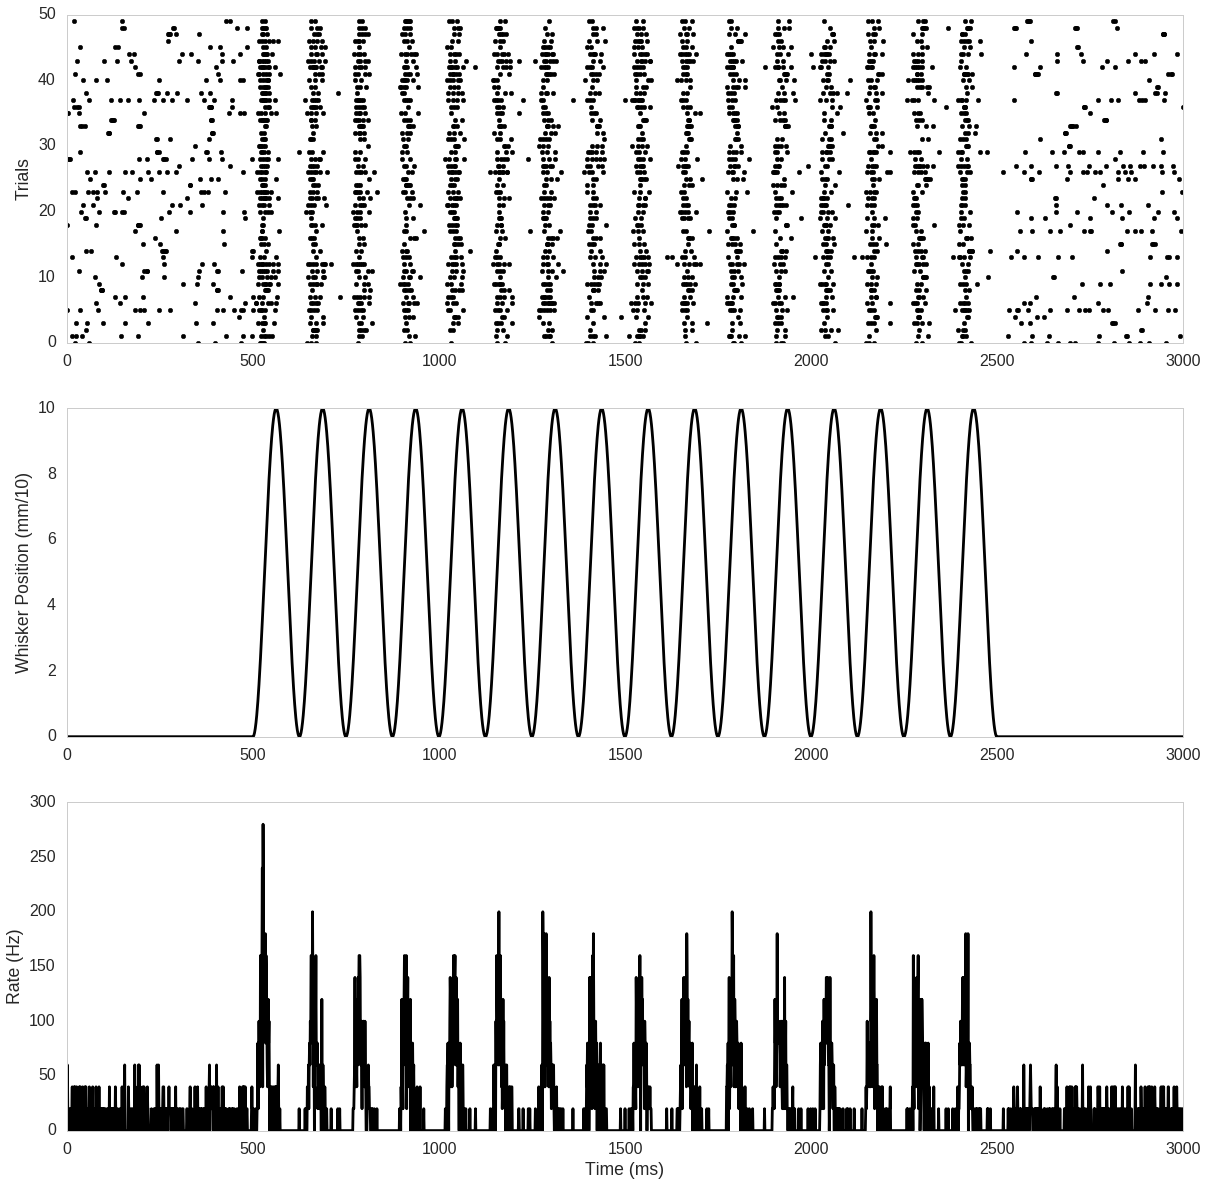

In [35]:
Rwhisker, Kwhisker = resp_values_whisker.shape
Iwhisker, Jwhisker = np.where(resp_values_whisker != 0)

# change the size of the figure [width, height]
fig1 = plt.figure(figsize=(20, 20)) 
subplot(3,1,1)

# turn on/off grid
plt.grid('off')

# Plot Raster
# change the size of the figure [width, height]
plt.scatter(Jwhisker, Iwhisker, c='black');
#plt.yticks(np.arange(0,50,5), ytick_labels, rotation='horizontal')

# axis dimensions
plt.xlim([0, 3000])
plt.ylim([0, 50])

# turn on/off grid
plt.grid('off')

# axis labels
plt.ylabel('Trials');#, fontsize = global_fontsize)

subplot(3,1,2)

# Plot Raster
# change the size of the figure [width, height]
#ax2 = plt.subplot(gs[:4,1:])
plt.plot(t[0][:3000],'k');
#plt.yticks(np.arange(0,50,5), ytick_labels, rotation='horizontal')

# axis dimensions
plt.xlim([0, 3000])
plt.ylim([0, 10])

# turn on/off grid
plt.grid('off');

plt.ylabel('Whisker Position (mm/10)');#, fontsize = global_fontsize)

subplot(3,1,3)
plt.grid('off');


plt.plot(mean(resp_values_whisker,axis=0)*1000,'k');

# axis labels
plt.ylabel('Rate (Hz)');
plt.xlabel('Time (ms)');#, fontsize = global_fontsize)

plt.show();

## Zoom in to raw data from whisking experiment

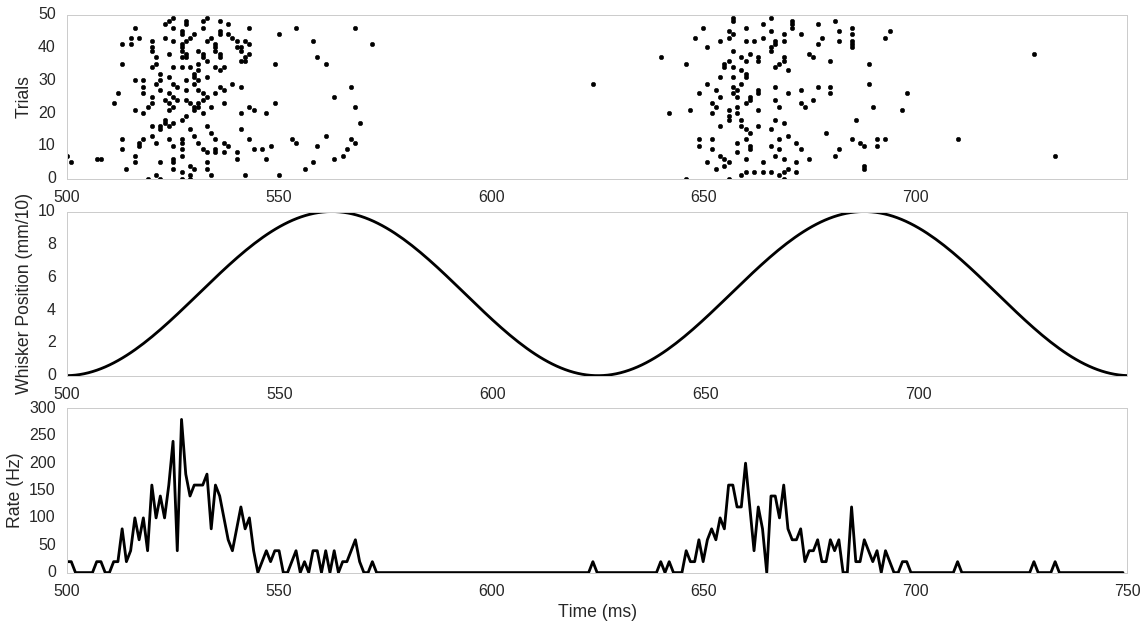

In [78]:
tzoom = np.arange(500,750)
IwhiskerZ, JwhiskerZ = np.where(resp_values_whisker[:,tzoom] != 0)

# change the size of the figure [width, height]
fig2 = plt.figure(figsize=(19, 10)) 
subplot(3,1,1)

# turn on/off grid
plt.grid('off')

# Plot Raster
# change the size of the figure [width, height]
plt.scatter(JwhiskerZ, IwhiskerZ, c='black');
xlim([0,250])
plt.xticks(np.arange(0,len(tzoom),50), np.arange(500,750,50), rotation='horizontal')

# axis dimensions
#plt.xlim([tzoom[0], tzoom[-1]])
plt.ylim([0, 50])

# turn on/off grid
plt.grid('off')

# axis labels
plt.ylabel('Trials');#, fontsize = global_fontsize)

subplot(3,1,2)

# Plot Raster
# change the size of the figure [width, height]
#ax2 = plt.subplot(gs[:4,1:])
plt.plot(np.arange(500,750),t[0][tzoom],'k');
#plt.yticks(np.arange(0,50,5), ytick_labels, rotation='horizontal')

# axis dimensions
plt.xlim([tzoom[0], tzoom[-1]])
plt.ylim([0, 10])

# turn on/off grid
plt.grid('off');

plt.ylabel('Whisker Position (mm/10)');#, fontsize = global_fontsize)

subplot(3,1,3)
plt.grid('off');


plt.plot(np.arange(500,750),mean(resp_values_whisker[:,tzoom],axis=0)*1000,'k');

# axis labels
plt.ylabel('Rate (Hz)');
plt.xlabel('Time (ms)');#, fontsize = global_fontsize)

plt.show();

## Application of binary filter to whisking data

In [37]:
# Run EM on the data to estimate optimal variance
pmode_whisker, p_whisker, pll_whisker, pul_whisker, sigma2e_whisker = RunEM(resp_values_whisker)
#plot_results(resp_values_1711, pmode_1711, p_1711, pll_1711, pul_1711, ylim=[0,0.75])

initial sigma2e is 0.25

Converged after 85 iterations
sigma2e is  0.0932236307885
runtime: 20.497410059 seconds


## Result of applying binary smoother to data from whisking experiment

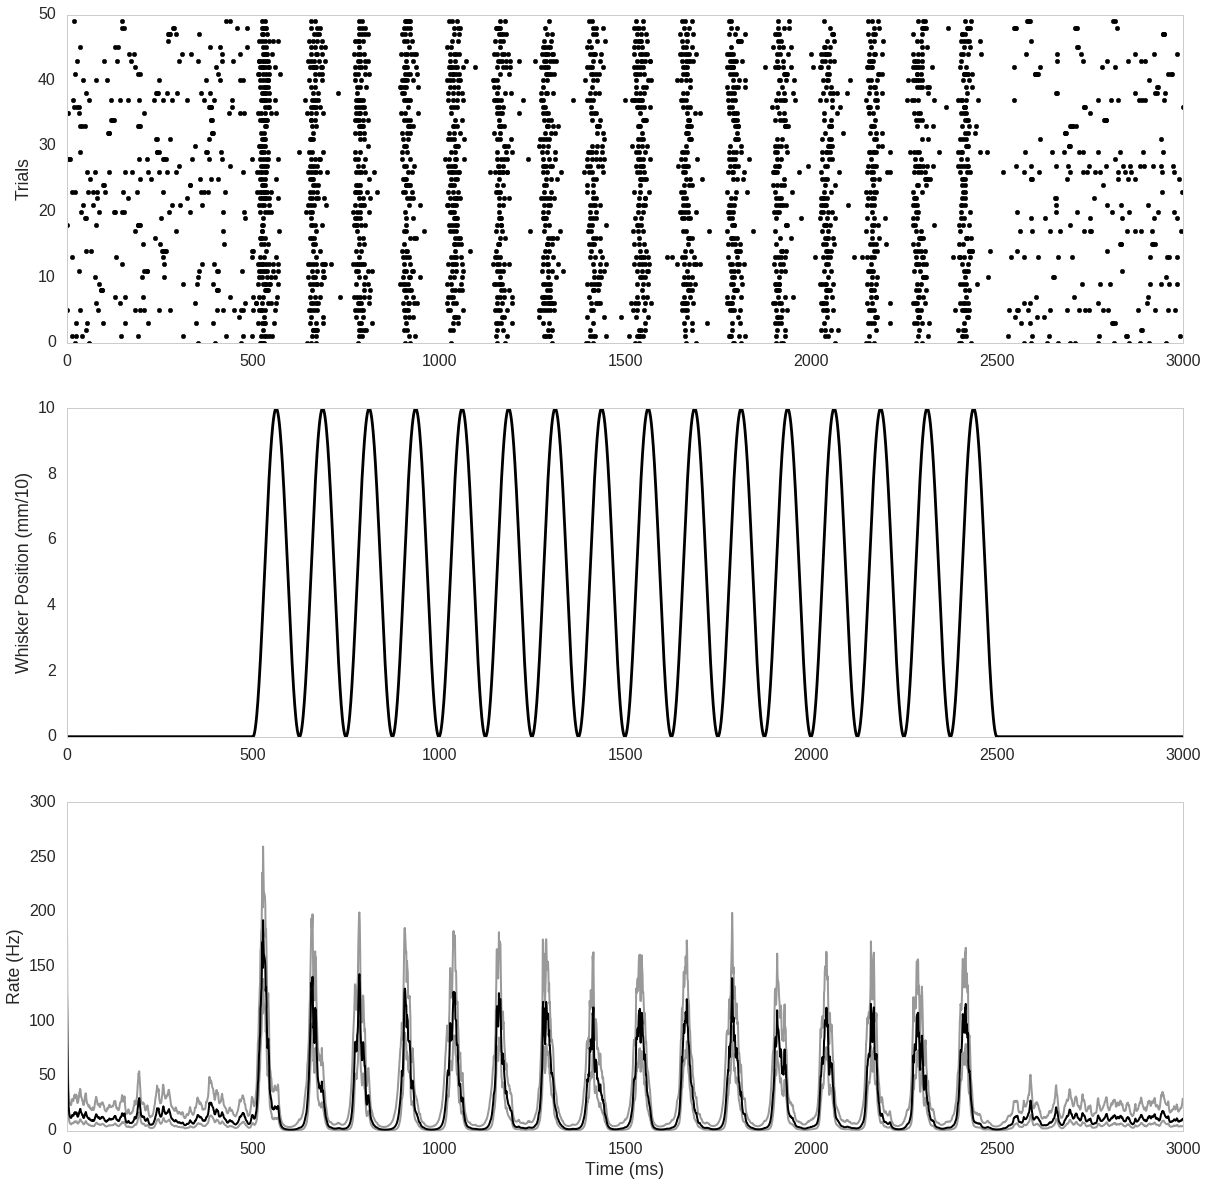

In [38]:
# change the size of the figure [width, height]
fig3 = plt.figure(figsize=(20, 20)) 
subplot(3,1,1)

# turn on/off grid
plt.grid('off')

# Plot Raster
# change the size of the figure [width, height]
plt.scatter(Jwhisker, Iwhisker, c='black');
#plt.yticks(np.arange(0,50,5), ytick_labels, rotation='horizontal')

# axis dimensions
plt.xlim([0, 3000])
plt.ylim([0, 50])

# turn on/off grid
plt.grid('off')

# axis labels
plt.ylabel('Trials');#, fontsize = global_fontsize)

subplot(3,1,2)

# Plot Raster
# change the size of the figure [width, height]
#ax2 = plt.subplot(gs[:4,1:])
plt.plot(t[0][:3000],'k');
#plt.yticks(np.arange(0,50,5), ytick_labels, rotation='horizontal')

# axis dimensions
plt.xlim([0, 3000])
plt.ylim([0, 10])

# turn on/off grid
plt.grid('off');

plt.ylabel('Whisker Position (mm/10)');#, fontsize = global_fontsize)

subplot(3,1,3)
plt.grid('off');

# plot probability
plt.plot(pmode_whisker*1000,  linestyle = '-', color= 'black', lw=2, label='model probability')

# plot uncertainty
plt.plot(pll_whisker*1000, color='black', alpha=0.4, lw=2, label='Uncertainty')
plt.plot(pul_whisker*1000, color='black', alpha=0.4, lw=2,)
#plt.ylim([0,0.75])
# axis labels
plt.ylabel('Rate (Hz)');
plt.xlabel('Time (ms)');#, fontsize = global_fontsize)

plt.show();

## Zoom into result of applying binary smoother to data from whisking experiment

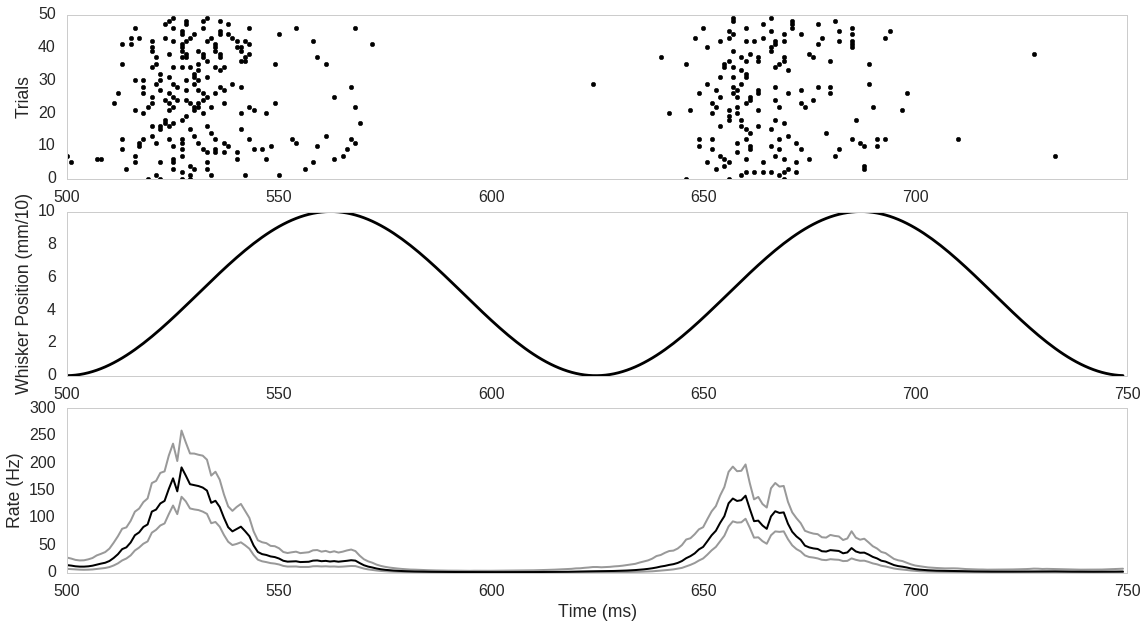

In [80]:
# change the size of the figure [width, height]
fig4 = plt.figure(figsize=(19, 10)) 
subplot(3,1,1)

# turn on/off grid
plt.grid('off')

# Plot Raster
# change the size of the figure [width, height]
xlim([0,250])
plt.scatter(JwhiskerZ, IwhiskerZ, c='black');
plt.xticks(np.arange(0,len(tzoom),50), np.arange(500,750,50), rotation='horizontal')

# axis dimensions
#plt.xlim([tzoom[0], tzoom[-1]])
plt.ylim([0, 50])

# turn on/off grid
plt.grid('off')

# axis labels
plt.ylabel('Trials');#, fontsize = global_fontsize)

subplot(3,1,2)

# Plot Raster
# change the size of the figure [width, height]
#ax2 = plt.subplot(gs[:4,1:])
plt.plot(np.arange(500,750),t[0][tzoom],'k');
#plt.yticks(np.arange(0,50,5), ytick_labels, rotation='horizontal')

# axis dimensions
#plt.xlim([tzoom[0], tzoom[-1]])
plt.ylim([0, 10])

# turn on/off grid
plt.grid('off');

plt.ylabel('Whisker Position (mm/10)');#, fontsize = global_fontsize)

subplot(3,1,3)
plt.grid('off');

# plot probability
plt.plot(np.arange(500,750),pmode_whisker[tzoom]*1000,  linestyle = '-', color= 'black', lw=2, label='model probability')

# plot uncertainty
plt.plot(np.arange(500,750),pll_whisker[tzoom]*1000, color='black', alpha=0.4, lw=2, label='Uncertainty')
plt.plot(np.arange(500,750),pul_whisker[tzoom]*1000, color='black', alpha=0.4, lw=2,)
#plt.ylim([0,0.75])
# axis labels
plt.ylabel('Rate (Hz)');
plt.xlabel('Time (ms)');#, fontsize = global_fontsize)

plt.show();


# Data from social learning of fear experiment in mice (ACC)

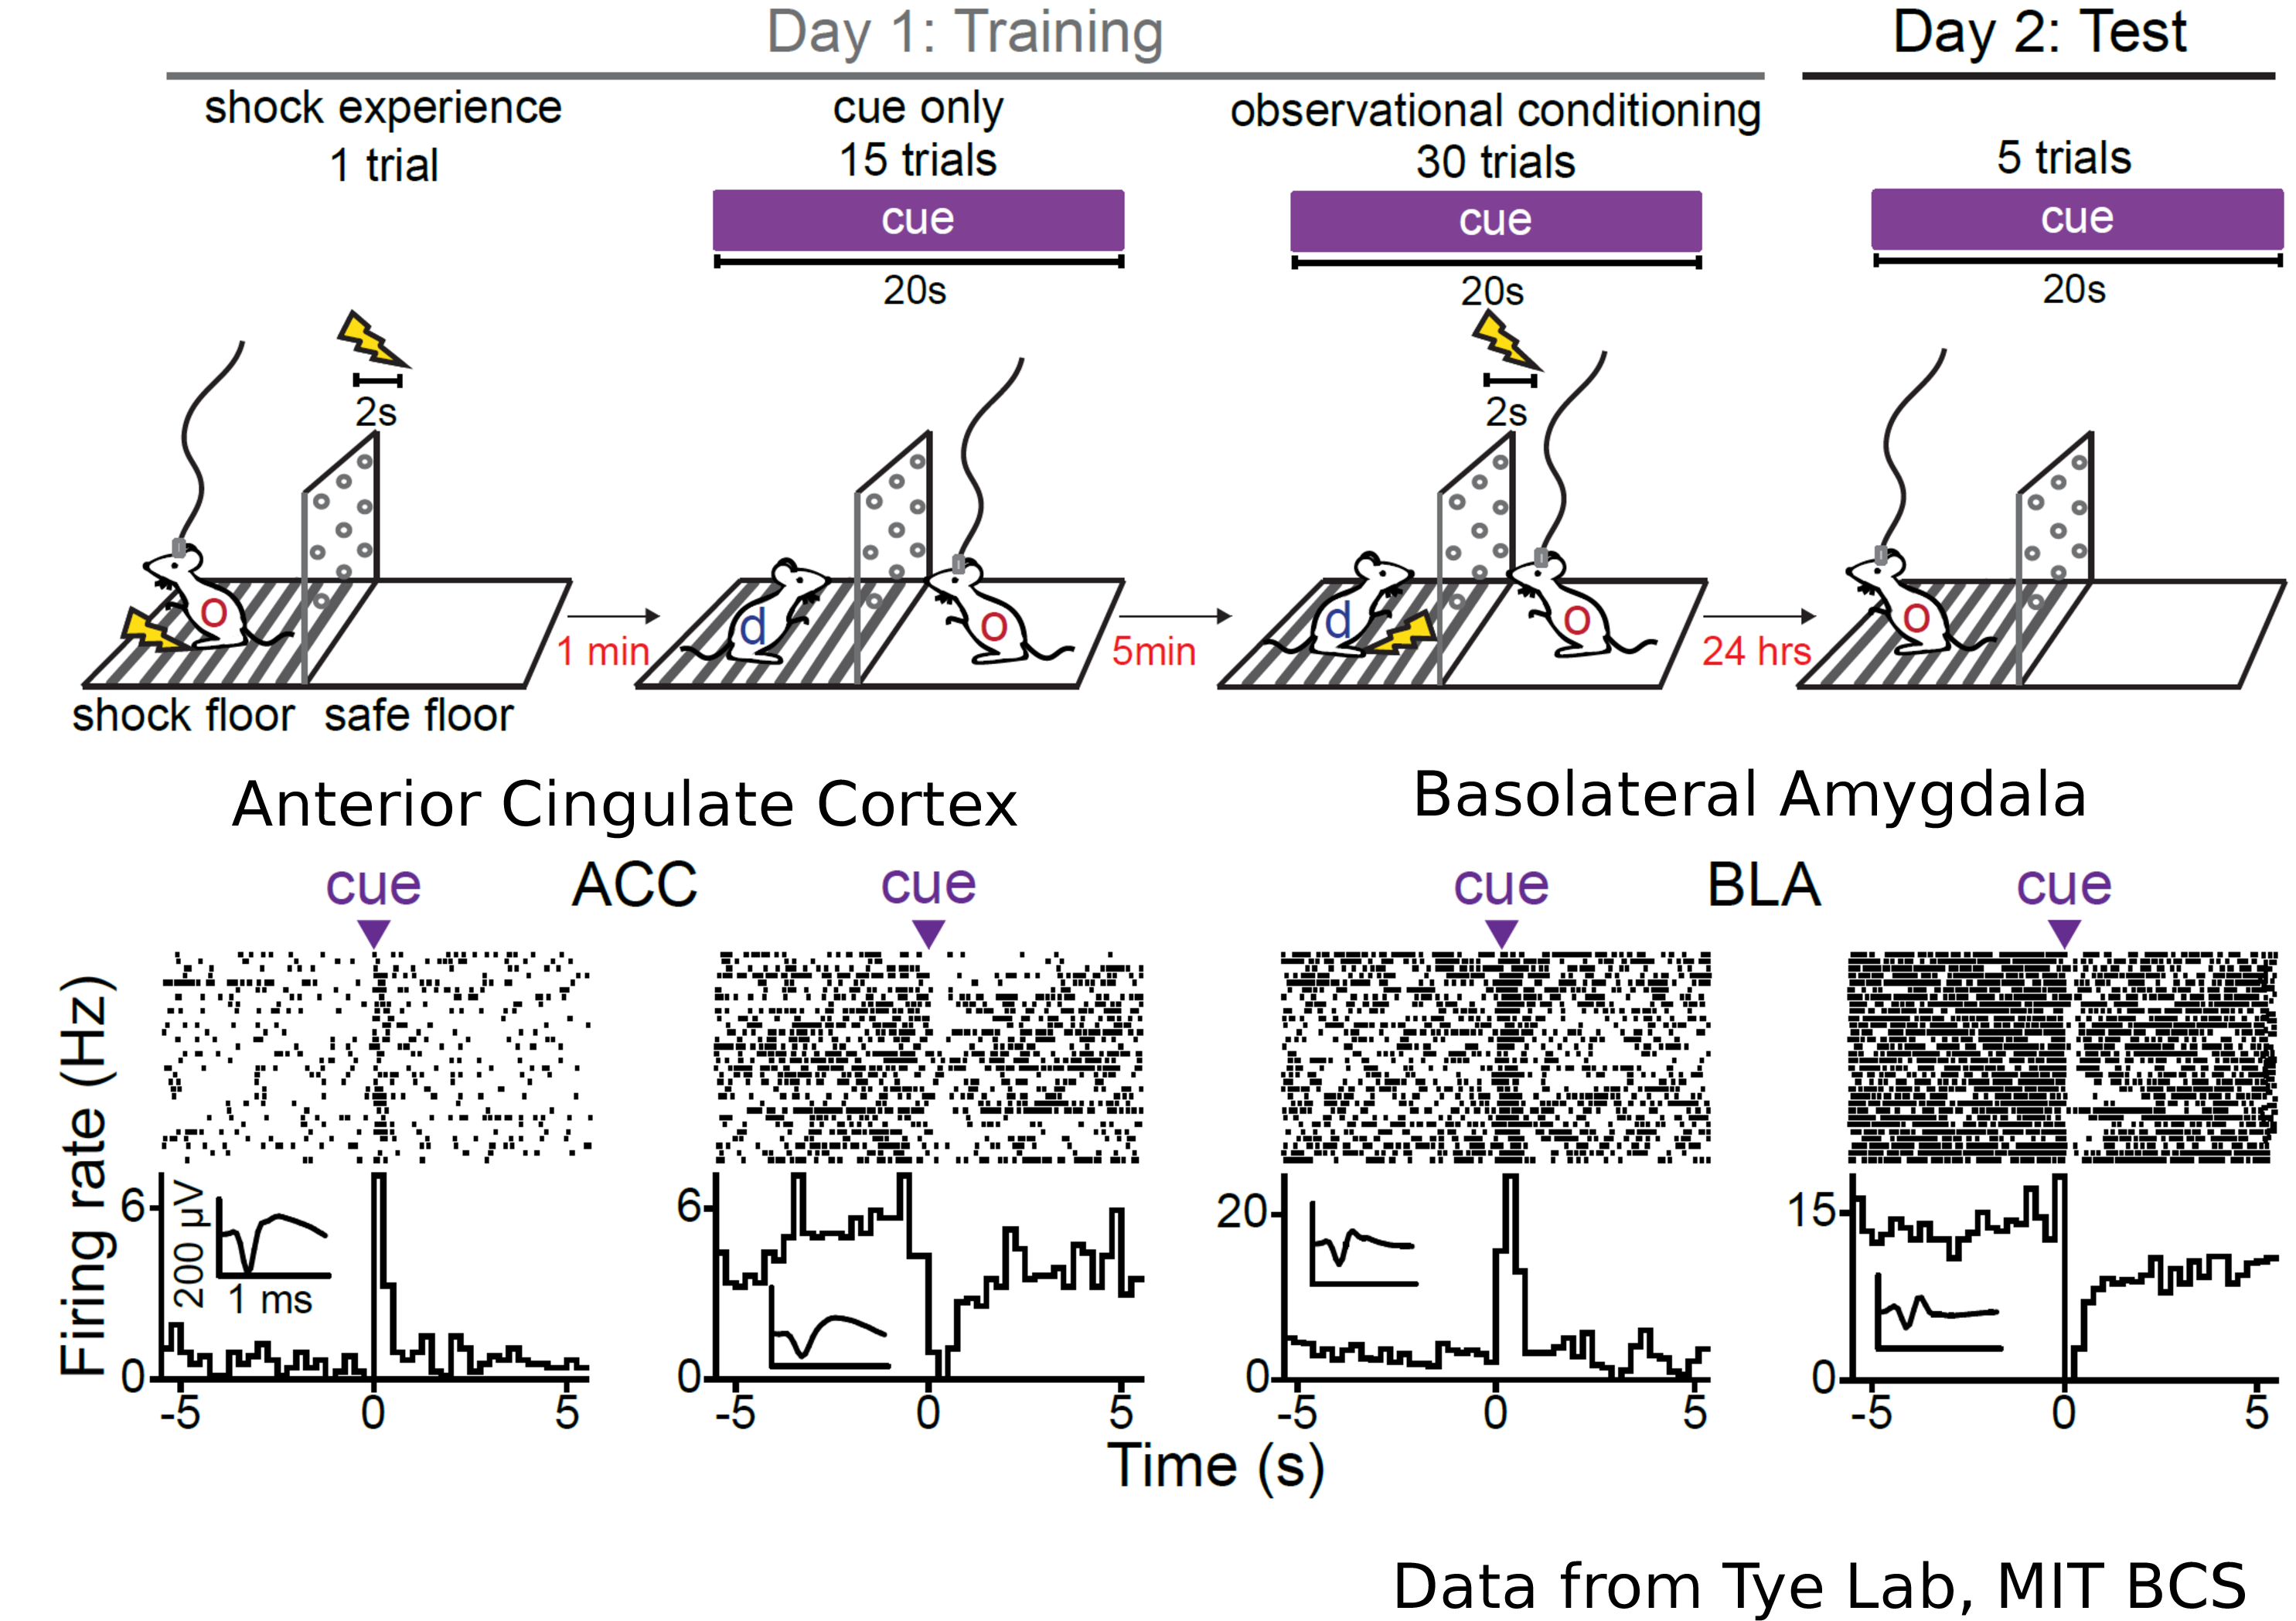

In [41]:
img2 = WImage(filename='obs_fear_xprmnt.pdf',resolution=600)
img2.size
img2

In [42]:
filename_ls = ['3189_obsfearfinal', '2193_obsfearfinal', '2192_obsfearfinal']
celnum_ls = ['16','02','15']
idx = 1
filename = filename_ls[idx]
celnum = celnum_ls[idx]
celletter = 'a'
baseln = 500
exprmt = 1500

# load the raw data from pickle file
resp_values_acc, pmode_k, pll_k, pul_k, pmode_r, pll_r, pul_r = pickle.load(open('/home/demba/students/cosyne2017/Pickled_Data/%s_raster.p'%filename[:4],'rb'))

## Raw data from one ACC neuron

In [43]:
Racc, Kacc = resp_values_acc.shape
Iacc, Jacc = np.where(resp_values_acc != 0)

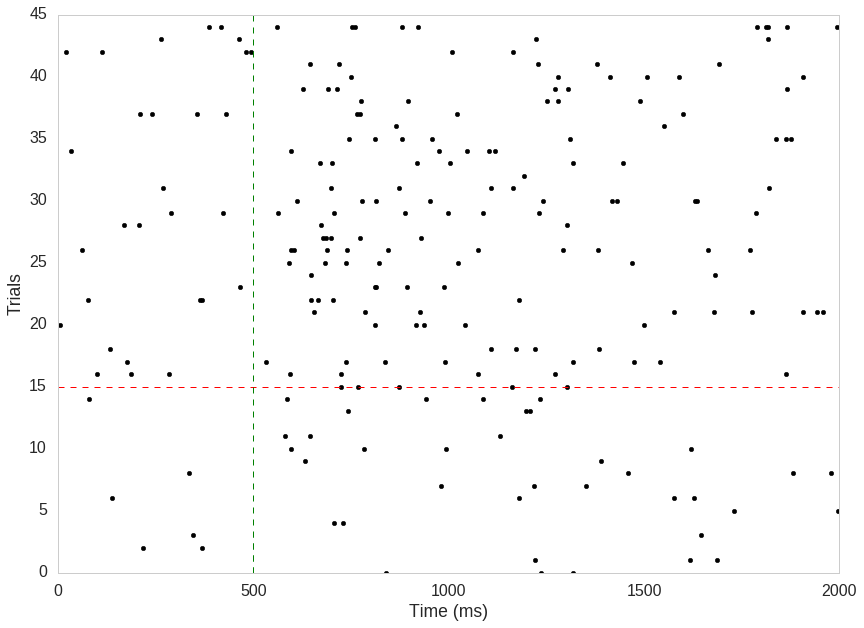

In [45]:
# change the size of the figure [width, height]
fig5 = plt.figure(figsize=(14, 10)) 

# turn on/off grid
plt.grid('off')

# Plot Raster
# change the size of the figure [width, height]
plt.scatter(Jacc, Iacc, c='black')
#plt.yticks(np.arange(0,46,5), ytick_labels, rotation='horizontal')

# hline
plt.hlines(15, 0, 2000, 'r',linestyle='--',lw = 1)
# vline
plt.vlines(500, 0, Racc, 'g',linestyle='--',lw = 1)

# axis dimensions
plt.xlim([0, 2000])
plt.ylim([0, 45])

# turn on/off grid
plt.grid('off')

# vline
plt.vlines(500, 0, np.max(pul_k), 'g',linestyle='--',lw = 1)
# legend
# plt.legend()

# axis labels
plt.xlabel('Time (ms)')#, fontsize = global_fontsize)
plt.ylabel('Trials')#, fontsize = global_fontsize)

# turn on/off grid
plt.grid('off')
plot_name = 'Neuron%s_%s%s' % (filename[:4], celnum, celletter) 

plt.show()

## Application of binary filter/smoother to ACC data across time

In [46]:
# Run EM on the data set to estimate optimal value of variance
pmode_ACCtime, p_ACCtime, pll_ACCtime, pul_ACCtime, sigma2e_ACCtime = RunEM(resp_values_acc)

initial sigma2e is 0.25

Converged after 186 iterations
sigma2e is  0.102177807261
runtime: 18.230891943 seconds


## Result of applying binary filter/smoother to ACC data across time

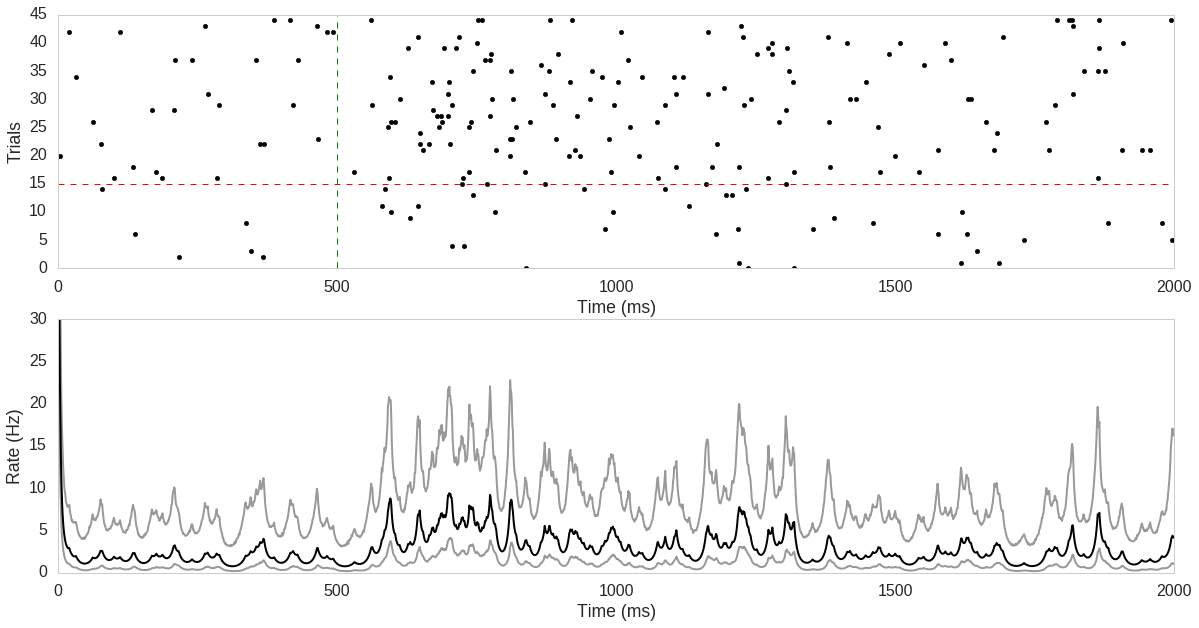

In [48]:
# change the size of the figure [width, height]
fig5 = plt.figure(figsize=(20, 10)) 
subplot(2,1,1)
# turn on/off grid
plt.grid('off')

# Plot Raster
# change the size of the figure [width, height]
plt.scatter(Jacc, Iacc, c='black')
#plt.yticks(np.arange(0,46,5), ytick_labels, rotation='horizontal')

# hline
plt.hlines(15, 0, 2000, 'r',linestyle='--',lw = 1)
# vline
plt.vlines(500, 0, Racc, 'g',linestyle='--',lw = 1)

# axis dimensions
plt.xlim([0, 2000])
plt.ylim([0, 45])


# vline
plt.vlines(500, 0, np.max(pul_k), 'g',linestyle='--',lw = 1)
# legend
# plt.legend()

# axis labels
plt.xlabel('Time (ms)')#, fontsize = global_fontsize)
plt.ylabel('Trials')#, fontsize = global_fontsize)

# turn on/off grid
plot_name = 'Neuron%s_%s%s' % (filename[:4], celnum, celletter) 

subplot(2,1,2)
plt.grid('off')

# plot probability
plt.plot(pmode_ACCtime*1000,  linestyle = '-', color= 'black', lw=2, label='model probability')

# plot uncertainty
plt.plot(pll_ACCtime*1000, color='black', alpha=0.4, lw=2, label='Uncertainty')
plt.plot(pul_ACCtime*1000, color='black', alpha=0.4, lw=2,)
plt.ylim([0,30])
# axis labels
plt.ylabel('Rate (Hz)');
plt.xlabel('Time (ms)');#, fontsize = global_fontsize)


plt.show()

## Application of binary filter/smoother to ACC data across trials

In [49]:
# Run EM on the data set to estimate optimal value of variance
pmode_ACCtrials, p_ACCtrials, pll_ACCtrials, pul_ACCtrials, sigma2e_ACCtrials = RunEM(resp_values_acc.T)

initial sigma2e is 0.25

Converged after 13 iterations
sigma2e is  1.3477027769
runtime: 0.377737998962 seconds


## Result of applying binary filter/smoother to ACC data across trials

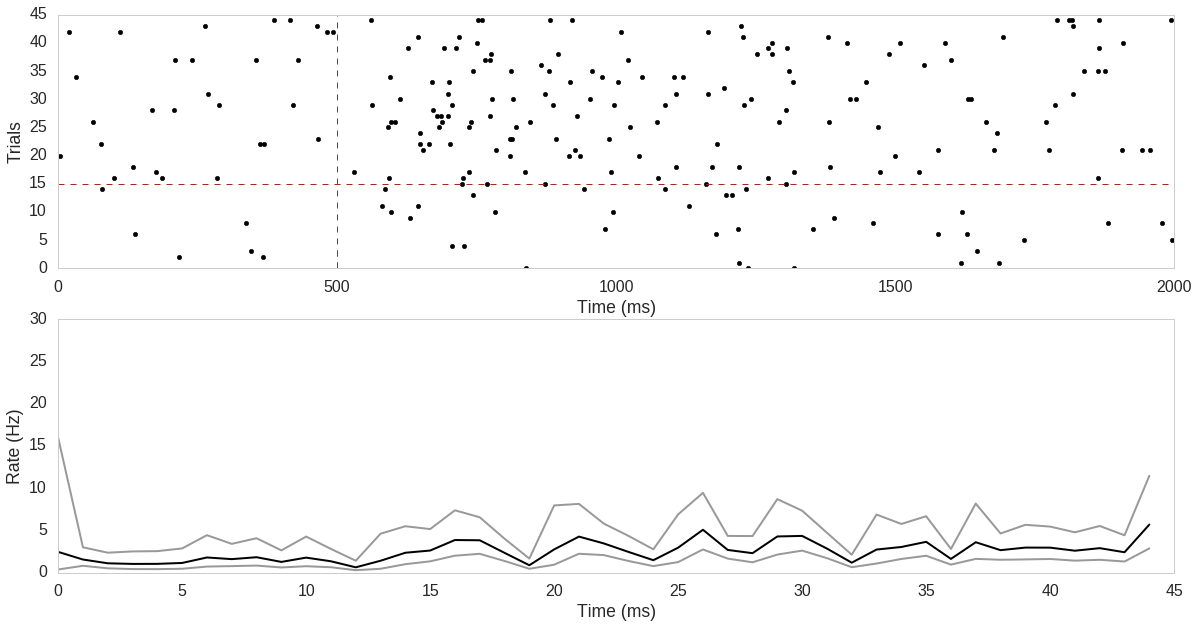

In [50]:
# change the size of the figure [width, height]
fig5 = plt.figure(figsize=(20, 10)) 
subplot(2,1,1)
# turn on/off grid
plt.grid('off')

# Plot Raster
# change the size of the figure [width, height]
plt.scatter(Jacc, Iacc, c='black')
#plt.yticks(np.arange(0,46,5), ytick_labels, rotation='horizontal')

# hline
plt.hlines(15, 0, 2000, 'r',linestyle='--',lw = 1)
# vline
plt.vlines(500, 0, Racc, 'g',linestyle='--',lw = 1)

# axis dimensions
plt.xlim([0, 2000])
plt.ylim([0, 45])


# vline
plt.vlines(500, 0, np.max(pul_k), 'g',linestyle='--',lw = 1)
# legend
# plt.legend()

# axis labels
plt.xlabel('Time (ms)')#, fontsize = global_fontsize)
plt.ylabel('Trials')#, fontsize = global_fontsize)

# turn on/off grid
plot_name = 'Neuron%s_%s%s' % (filename[:4], celnum, celletter) 

subplot(2,1,2)
plt.grid('off')

# plot probability
plt.plot(pmode_ACCtrials*1000,  linestyle = '-', color= 'black', lw=2, label='model probability')

# plot uncertainty
plt.plot(pll_ACCtrials*1000, color='black', alpha=0.4, lw=2, label='Uncertainty')
plt.plot(pul_ACCtrials*1000, color='black', alpha=0.4, lw=2,)
plt.ylim([0,30])
# axis labels
plt.ylabel('Rate (Hz)');
plt.xlabel('Time (ms)');#, fontsize = global_fontsize)


plt.show()

# Data from Monkey set shifting experiment

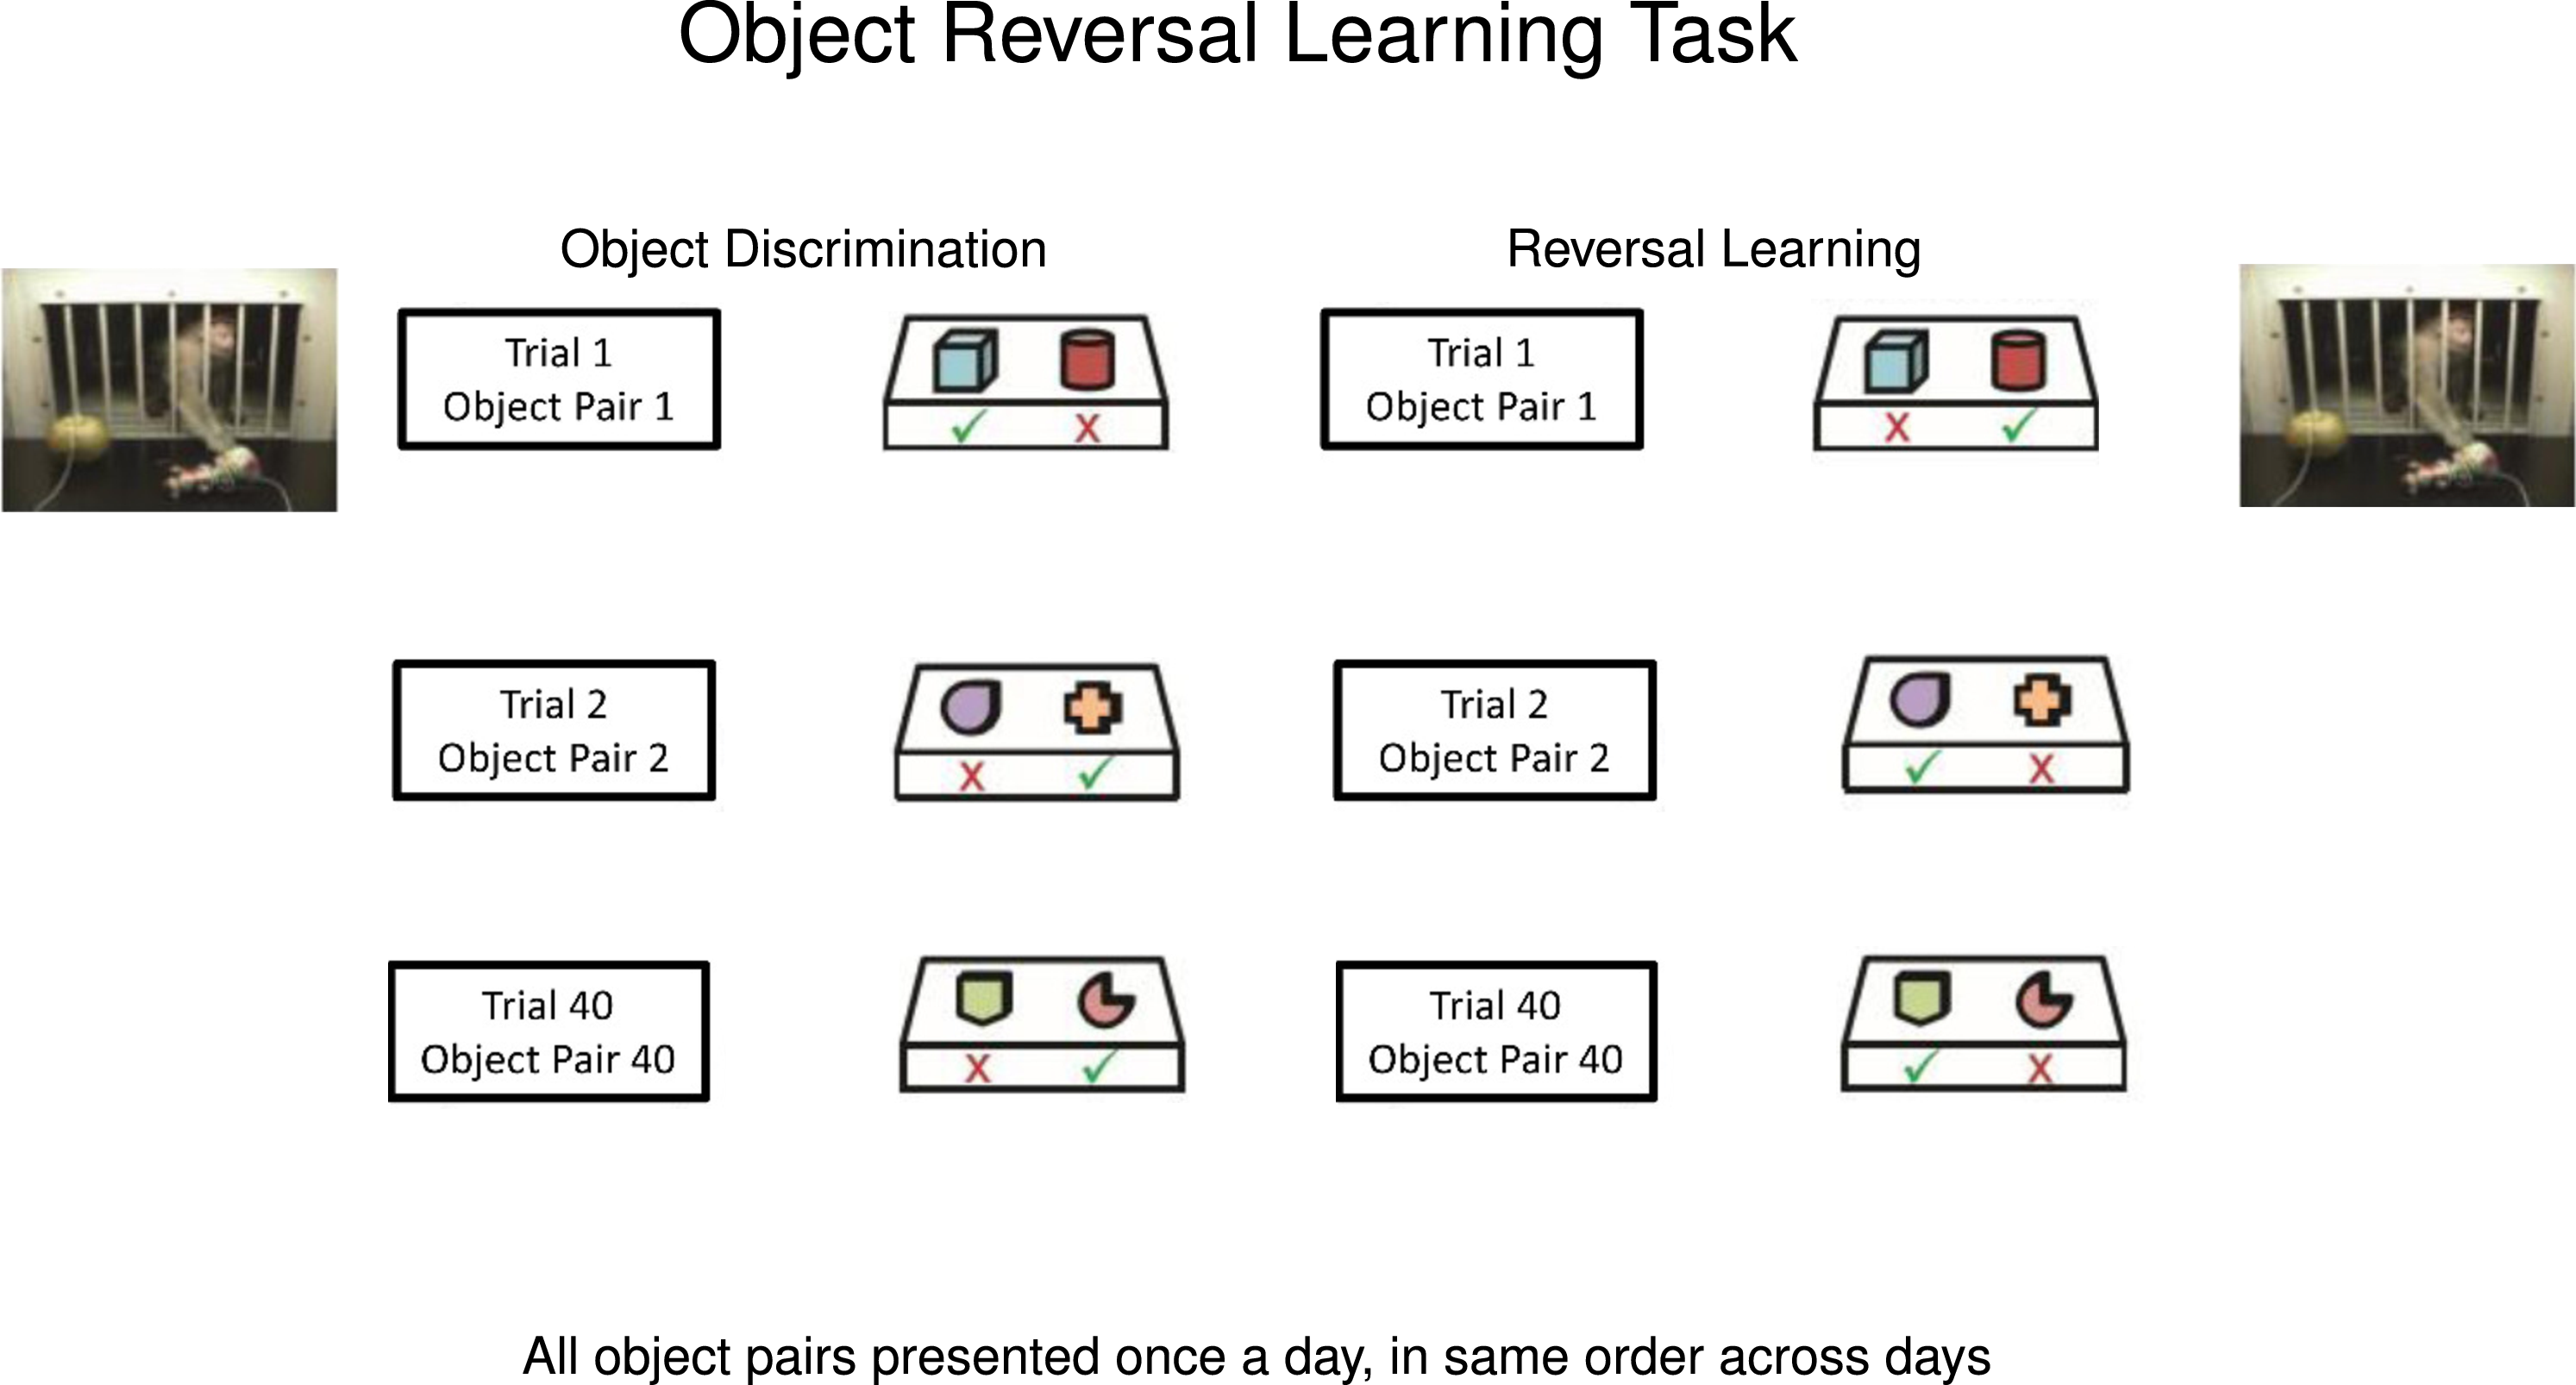

In [51]:
img3 = WImage(filename = 'setshiftingtasksmall.pdf',resolution=600)
img3

In [54]:
resp_cirrus = pickle.load(open('Cirrus_old.p','rb'))
resp_nimbus = pickle.load(open('Nimbus_young.p','rb'))

flag = 0 # cirrus
if flag:
    resp_monkey = resp_cirrus
    num_OD_days = 44.5
    monkey_name = 'Cirrus (old)'
else:
    resp_monkey = resp_nimbus
    num_OD_days = 19.5
    monkey_name = 'Nimbus (young)'

## Raw data from Monkey

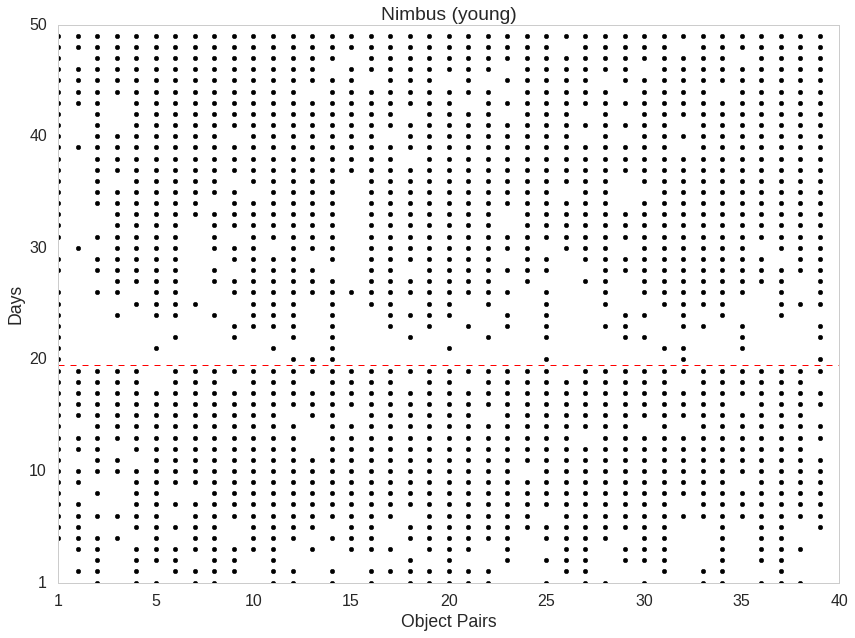

In [55]:
# change the size of the figure [width, height]
fig7 = plt.figure(figsize=(14, 10)) 
Rmonkey, Kmonkey = resp_monkey.shape
Imonkey, Jmonkey = np.where(resp_monkey != 0)

plt.scatter(Jmonkey, Imonkey, c='black');
plt.xticks(np.arange(0,Kmonkey+1,5), np.hstack(([1],np.arange(0,Kmonkey+1,5)[1:])), rotation='horizontal')
plt.yticks(np.arange(0,Rmonkey+1,10), np.hstack(([1],np.arange(0,Rmonkey+1,10)[1:])), rotation='horizontal')

plt.grid('off')
plt.xlim([0,Kmonkey])
plt.ylim([0,Rmonkey])
plt.xlabel('Object Pairs')
plt.ylabel('Days')
# hline
plt.hlines(num_OD_days, 0, 40, 'r',linestyle='--',lw = 1)
plt.title(monkey_name)

## Application of binary filter/smoother to Monkey data across objects

In [56]:
# Run EM on the data set to estimate optimal value of variance
pmode_monkeyo, p_monkeyo, pll_monkeyo, pul_monkeyo, sigma2e_monkeyo = RunEM(resp_monkey)

initial sigma2e is 0.25

Converged after 29 iterations
sigma2e is  0.334604258664
runtime: 0.244341850281 seconds


## Result of applying binary filter/smoother to Monday data across objects

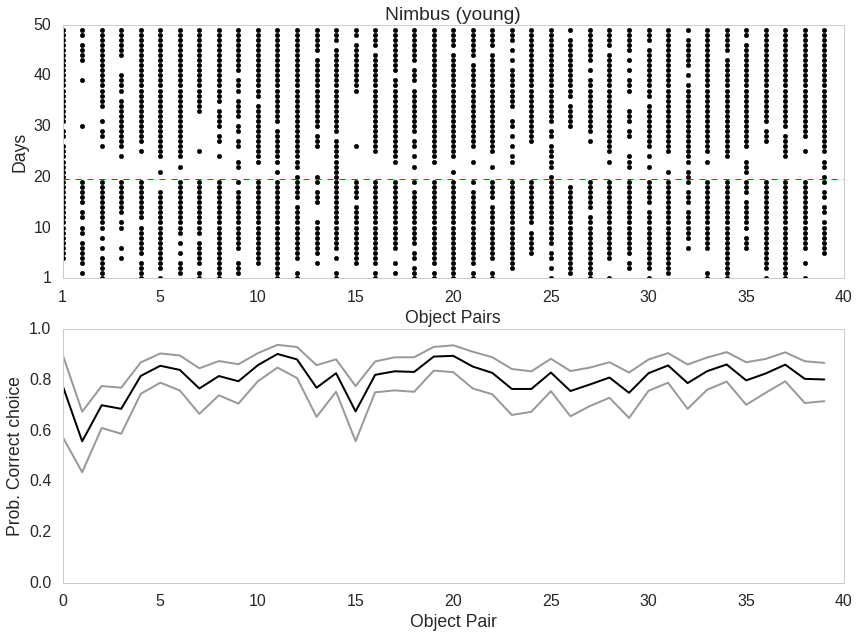

In [57]:
# change the size of the figure [width, height]
fig8 = plt.figure(figsize=(14, 10)) 
Rmonkey, Kmonkey = resp_monkey.shape
Imonkey, Jmonkey = np.where(resp_monkey != 0)

subplot(2,1,1)
plt.scatter(Jmonkey, Imonkey, c='black');
plt.xticks(np.arange(0,Kmonkey+1,5), np.hstack(([1],np.arange(0,Kmonkey+1,5)[1:])), rotation='horizontal')
plt.yticks(np.arange(0,Rmonkey+1,10), np.hstack(([1],np.arange(0,Rmonkey+1,10)[1:])), rotation='horizontal')

plt.grid('off')
plt.xlim([0,Kmonkey])
plt.ylim([0,Rmonkey])
plt.xlabel('Object Pairs')
plt.ylabel('Days')
# hline
plt.hlines(num_OD_days, 0, 40, 'r',linestyle='--',lw = 1)
plt.title(monkey_name)

subplot(2,1,2)
plt.grid('off')

# plot probability
plt.plot(pmode_monkeyo,  linestyle = '-', color= 'black', lw=2, label='model probability')

# plot uncertainty
plt.plot(pll_monkeyo, color='black', alpha=0.4, lw=2, label='Uncertainty')
plt.plot(pul_monkeyo, color='black', alpha=0.4, lw=2,)
plt.ylim([0,1])
# axis labels
plt.ylabel('Prob. Correct choice');
plt.xlabel('Object Pair');#, fontsize = global_fontsize)

## Application of binary filter/smoother to Monkey data across days

In [58]:
# Run EM on the data set to estimate optimal value of variance
pmode_monkeyd, p_monkeyd, pll_monkeyd, pul_monkeyd, sigma2e_monkeyd = RunEM(resp_monkey.T)

initial sigma2e is 0.25

Converged after 20 iterations
sigma2e is  0.346530619554
runtime: 0.238250017166 seconds


## Result of applying binary filter/smoother to monkey data across days

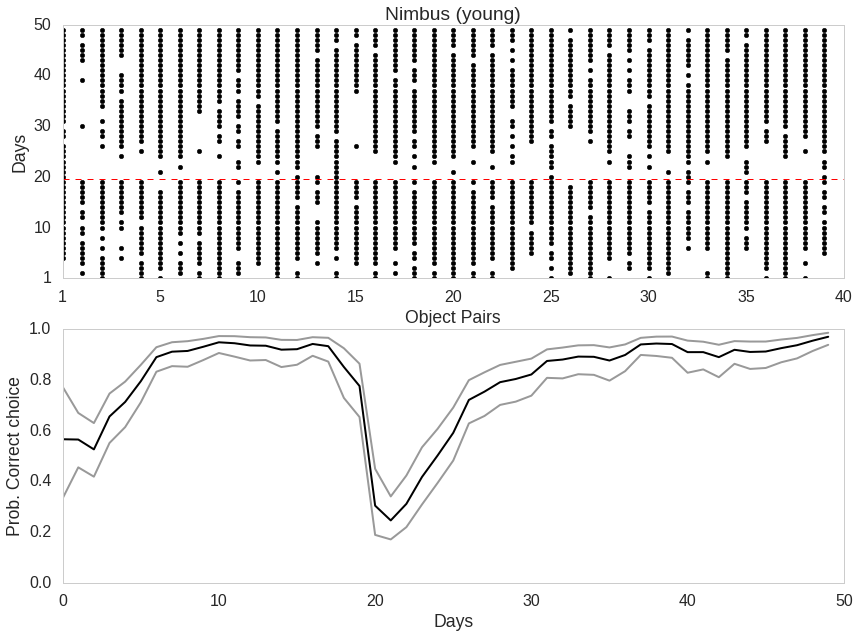

In [59]:
# change the size of the figure [width, height]
fig8 = plt.figure(figsize=(14, 10)) 
Rmonkey, Kmonkey = resp_monkey.shape
Imonkey, Jmonkey = np.where(resp_monkey != 0)

subplot(2,1,1)
plt.scatter(Jmonkey, Imonkey, c='black');
plt.xticks(np.arange(0,Kmonkey+1,5), np.hstack(([1],np.arange(0,Kmonkey+1,5)[1:])), rotation='horizontal')
plt.yticks(np.arange(0,Rmonkey+1,10), np.hstack(([1],np.arange(0,Rmonkey+1,10)[1:])), rotation='horizontal')

plt.grid('off')
plt.xlim([0,Kmonkey])
plt.ylim([0,Rmonkey])
plt.xlabel('Object Pairs')
plt.ylabel('Days')
# hline
plt.hlines(num_OD_days, 0, 40, 'r',linestyle='--',lw = 1)
plt.title(monkey_name)

subplot(2,1,2)
plt.grid('off')

# plot probability
plt.plot(pmode_monkeyd,  linestyle = '-', color= 'black', lw=2, label='model probability')

# plot uncertainty
plt.plot(pll_monkeyd, color='black', alpha=0.4, lw=2, label='Uncertainty')
plt.plot(pul_monkeyd, color='black', alpha=0.4, lw=2,)
plt.ylim([0,1])
# axis labels
plt.ylabel('Prob. Correct choice');
plt.xlabel('Days');#, fontsize = global_fontsize)